In [ ]:
#the code pipeline for the feature extraction for respiratory methods are highly similar with few differences
#below, we show how to extract features for one participant using the thorax RIP raw data


# FEATURE EXTRACTION EXAMPLE FOR THORAX RIP OF A PARTICIPANT

In [1]:
import pandas as pd
#we first read in a data set of one participant as an example
#it contains the raw Thorax RIP data (already inverted around the x axis so the increases represent inspiration)
#it also contains a column called Task_Label_2 which includes our task labels for the procedure

#data can also be read in from other formats as long as it is turned into a pandas dataframe format

#the dataframe should not be datetime indexed. if it is, drop the indexes before following with the next 
import pandas as pd

# read the HDF5 file into a DataFrame
df_thorax = pd.read_hdf('df_thorax.h5', 'df_thorax')

df_thorax


RSP_Raw Task_Label_2
0      -23878.000000         10.0
1      -23882.796222         10.0
2      -23879.000000         10.0
3      -23876.661824         10.0
4      -23879.000000         10.0
...              ...          ...
959996 -24066.000000         94.0
959997 -24062.018997         94.0
959998 -24066.000000         94.0
959999 -24080.221402         94.0
960000 -24066.000000         94.0

[960001 rows x 2 columns]

In [2]:
#below, we are customizing the steps of respiration processing and defining the function via neurokit2
#the main steps include cleaning and identification of troughs and peaks
def my_cleaning(rsp_signal, sampling_rate):
    # My custom cleaning logic
    cleaned = nk.signal_filter(
        rsp_signal,
        sampling_rate=sampling_rate,
        lowcut=0.05,
        highcut=0.60,
        order=2,
        method='butterworth'
    )
    return cleaned

import pandas as pd

from neurokit2 import as_vector
from neurokit2 import signal_rate
from neurokit2 import rsp_amplitude
from neurokit2 import rsp_clean
from neurokit2 import rsp_methods
from neurokit2 import rsp_peaks
from neurokit2 import rsp_phase
from neurokit2 import rsp_plot
from neurokit2 import rsp_rvt
from neurokit2 import rsp_symmetry

def my_process_hexoskin(
    rsp_signal,
    sampling_rate=256,
    method="scipy",
    method_rvt="harrison2021",
    report=None,
    **kwargs
):
    """**Process a respiration (RSP) signal**

    Convenience function that automatically processes a respiration signal with one of the
    following methods:

    * `Khodadad et al. (2018) <https://iopscience.iop.org/article/10.1088/1361-6579/aad7e6/meta>`_

    * `BioSPPy <https://github.com/PIA-Group/BioSPPy/blob/master/biosppy/signals/resp.py>`_

    Parameters
    ----------
    rsp_signal : Union[list, np.array, pd.Series]
        The raw respiration channel (as measured, for instance, by a respiration belt).
    sampling_rate : int
        The sampling frequency of :func:`.rsp_signal` (in Hz, i.e., samples/second).
    method : str
        The processing pipeline to apply. Can be one of ``"khodadad2018"`` (default)
        or ``"biosppy"``.
    method_rvt : str
        The rvt method to apply. Can be one of ``"harrison2021"`` (default), ``"birn2006"``
        or ``"power2020"``.
    report : str
        The filename of a report containing description and figures of processing
        (e.g. ``"myreport.html"``). Needs to be supplied if a report file
        should be generated. Defaults to ``None``. Can also be ``"text"`` to
        just print the text in the console without saving anything.
    **kwargs
        Other arguments to be passed to specific methods. For more information,
        see :func:`.rsp_methods`.

    Returns
    -------
    signals : DataFrame
        A DataFrame of same length as :func:`.rsp_signal` containing the following columns:

        * ``"RSP_Raw"``: the raw signal.
        * ``"RSP_Clean"``: the cleaned signal.
        * ``"RSP_Peaks"``: the respiratory peaks (exhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Troughs"``: the respiratory troughs (inhalation onsets) marked as "1" in a list of
          zeros.
        * ``"RSP_Rate"``: breathing rate interpolated between inhalation peaks.
        * ``"RSP_Amplitude"``: breathing amplitude interpolated between inhalation peaks.
        * ``"RSP_Phase"``: breathing phase, marked by "1" for inspiration and "0" for expiration.
        * ``"RSP_PhaseCompletion"``: breathing phase completion, expressed in percentage (from 0 to
          1), representing the stage of the current respiratory phase.
         * ``"RSP_RVT"``: respiratory volume per time (RVT).
    info : dict
        A dictionary containing the samples at which inhalation peaks and exhalation troughs occur,
        accessible with the keys ``"RSP_Peaks"``, and ``"RSP_Troughs"`` respectively, as well as the
        signals' sampling rate.

    See Also
    --------
    rsp_clean, rsp_findpeaks, .signal_rate, rsp_amplitude, rsp_plot, rsp_phase, rsp_rvt, rsp_symmetry

    Examples
    --------
    .. ipython:: python

      import neurokit2 as nk

      rsp = nk.rsp_simulate(duration=90, respiratory_rate=15)
      signals, info = nk.rsp_process(rsp, sampling_rate=250, report="text")

      @savefig p_rsp_process_1.png scale=100%
      fig = nk.rsp_plot(signals, sampling_rate=250)
      @suppress
      plt.close()

    """
    # sanitize input
    rsp_signal = as_vector(rsp_signal)
    methods = rsp_methods(
        sampling_rate=sampling_rate, method=method, method_rvt=method_rvt, **kwargs
    )

    # clean signal
    rsp_cleaned = my_cleaning(rsp_signal, sampling_rate=sampling_rate)

    # extract, fix and format peaks
    peak_signal, info = rsp_peaks(
        rsp_cleaned,
        sampling_rate=sampling_rate,
        method=methods["method_peaks"],
        peak_distance=1.65, 
        **methods["kwargs_peaks"]
    )
    
    info["sampling_rate"] = sampling_rate  # Add sampling rate in dict info

    # getting additional parameters
    phase = rsp_phase(peak_signal, desired_length=len(rsp_signal))
    amplitude = rsp_amplitude(rsp_cleaned, peak_signal)
    rate = signal_rate(
        info["RSP_Troughs"], sampling_rate=sampling_rate, desired_length=len(rsp_signal)
    )
    symmetry = rsp_symmetry(rsp_cleaned, peak_signal)
    rvt = rsp_rvt(
        rsp_cleaned,
        method=methods["method_rvt"],
        sampling_rate=sampling_rate,
        silent=True,
    )

    # preparing output
    signals = pd.DataFrame(
        {
            "RSP_Raw": rsp_signal,
            "RSP_Clean": rsp_cleaned,
            "RSP_Amplitude": amplitude,
            "RSP_Rate": rate,
            "RSP_RVT": rvt,
        }
    )
    signals = pd.concat([signals, phase, symmetry, peak_signal], axis=1)

    if report is not None:
       
        if ".html" in str(report):
            fig = rsp_plot(signals, sampling_rate=sampling_rate)
        else:
            fig = None
        create_report(file=report, signals=signals, info=methods, fig=fig)

    return signals, info


In [3]:
#below, we define a function which will, for each of the task names we enter, clean the segments of interest and do
#peak trough detection within the 30-sec segment entered along with the 5 seconds before and after each segment
#it creates a new dataframe per segment with RSP_Raw (stays same), RSP_Cleaned, and RSP_Peaks, RSP_Troughs
#Whenever there is a peak, RSP_Peaks = 1, and whenever there is a trough, RSP_Troughs = 1

#the function also visualizes the cleaned segments with the peak and troughs
participant_id = 58682 #this changes for each participant, needed only for the visualizations (is on the title of each graph)

def process_and_visualize(results_hexoskin, tasks):
    hexoskin_data = df_thorax
    tasks_dataframes = {}

    # Segmenting the dataframe into task-specific dataframes
    for task in tasks:
        task_indices = hexoskin_data[hexoskin_data['Task_Label_2'] == task].index

        if not task_indices.empty:
            start_index = task_indices[0] - 1280
            end_index = task_indices[-1] + 1280
            start_index = max(start_index, 0)
            end_index = min(end_index, len(hexoskin_data) - 1)
            task_dataframe = hexoskin_data.loc[start_index:end_index, ['RSP_Raw', 'Task_Label_2']]
            tasks_dataframes[task] = task_dataframe

    # processing each task-specific dataframe
    processed_tasks_dataframes = {}
    for task, task_df in tasks_dataframes.items():
        rsp_signal = task_df['RSP_Raw']
        processed_data, _ = my_process_hexoskin(rsp_signal, sampling_rate=256)
        processed_data.reset_index(drop=True, inplace=True)
        task_df_reset = task_df.reset_index(drop=True)
        processed_data_with_label = processed_data.merge(task_df_reset[['Task_Label_2']], left_index=True, right_index=True, how='left')
        processed_tasks_dataframes[task] = processed_data_with_label

    # visualizing the actual task portions - portions of interest
    for task, df in processed_tasks_dataframes.items():
        task_specific_indices = df.index[df['Task_Label_2'] == task]
        if not task_specific_indices.empty:
            task_start = task_specific_indices[0]
            task_end = task_specific_indices[-1]

            plt.figure(figsize=(15, 4))
            plt.plot(df.loc[task_start:task_end, 'RSP_Clean'], label='RSP_Clean', color='black')
            peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
            troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index

            for peak in peaks:
                plt.axvline(x=peak, color='red', linestyle='--', alpha=0.7)
            for trough in troughs:
                plt.axvline(x=trough, color='blue', linestyle='--', alpha=0.7)

            plt.title(f"Participant {participant_id}, Task: {task}")
            plt.xlabel("Samples")
            plt.ylabel("RSP_Clean")
            plt.legend()
            plt.show()
    
    return processed_tasks_dataframes


C:\Users\msa583\AppData\Local\Temp\ipykernel_472\1947522911.py:44: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  peaks = df.loc[task_start:task_end][df['RSP_Peaks'] == 1].index
C:\Users\msa583\AppData\Local\Temp\ipykernel_472\1947522911.py:45: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  troughs = df.loc[task_start:task_end][df['RSP_Troughs'] == 1].index


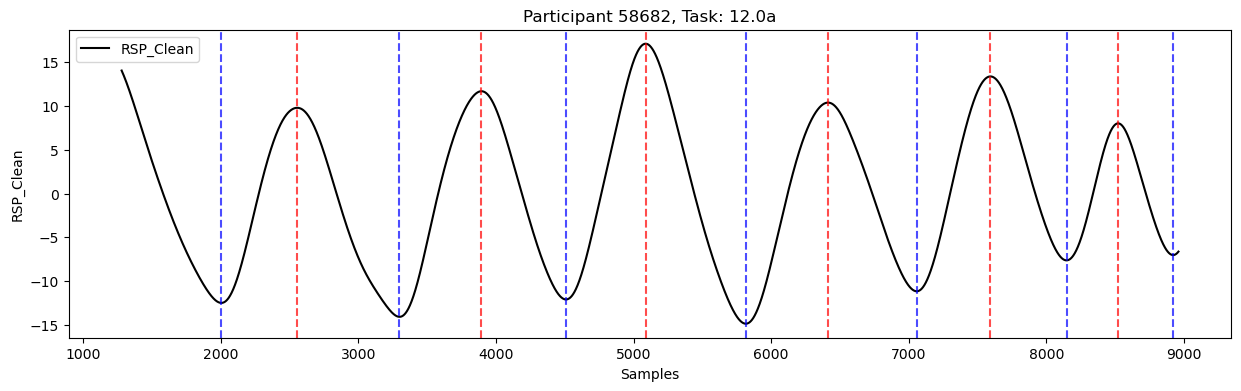

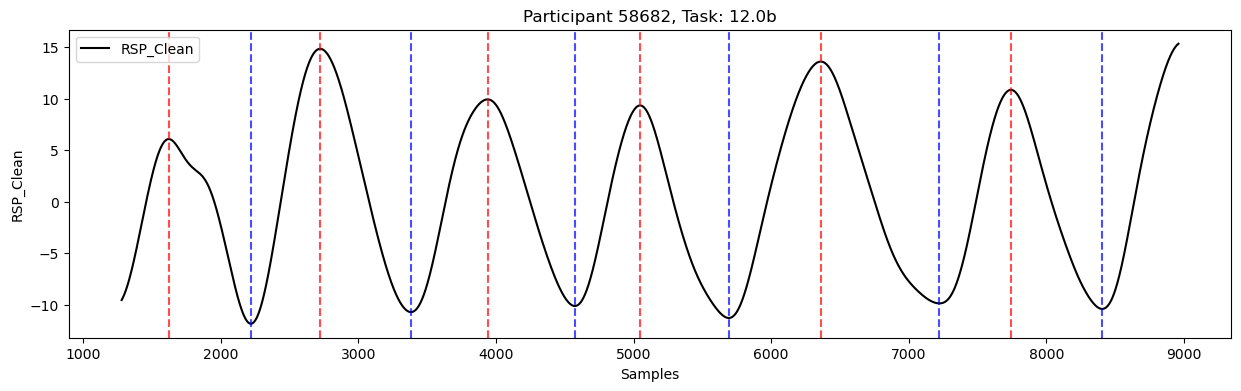

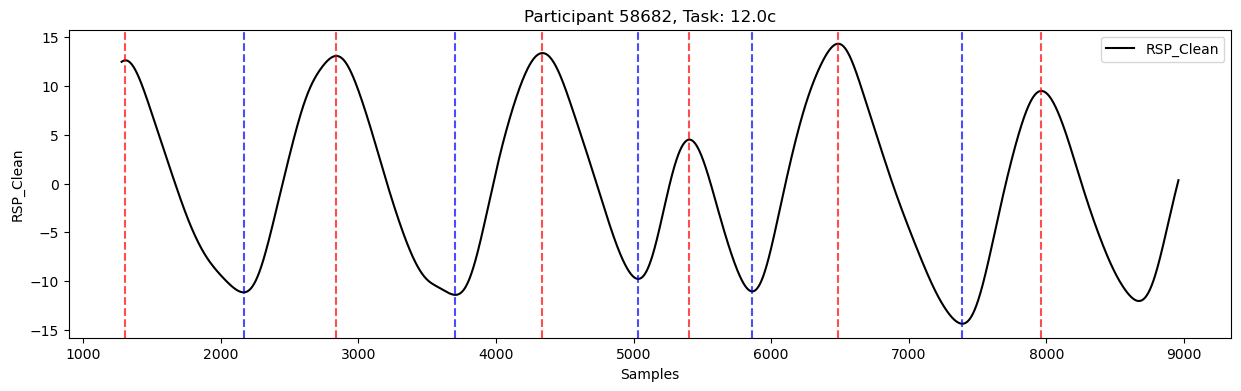

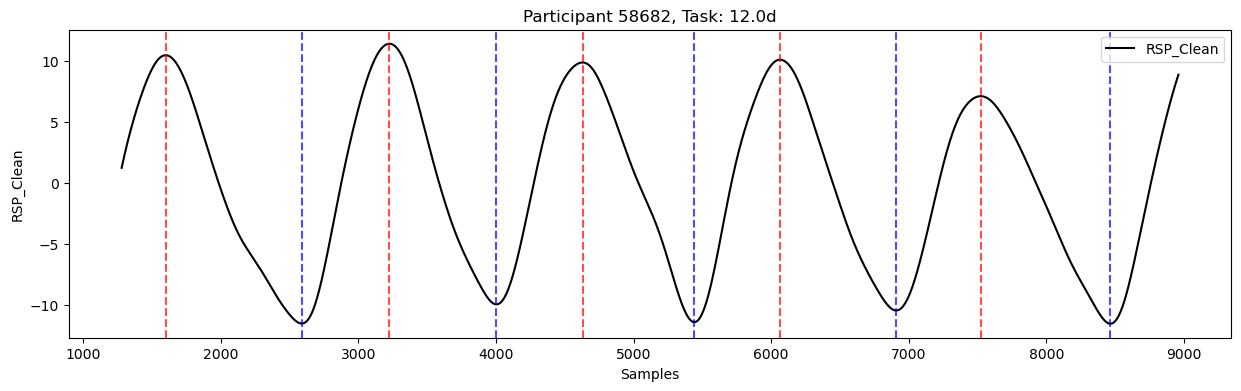

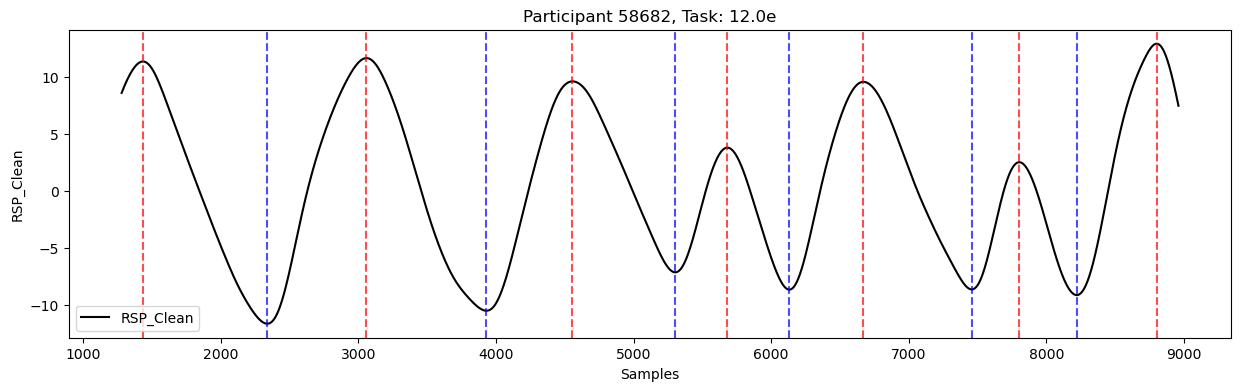

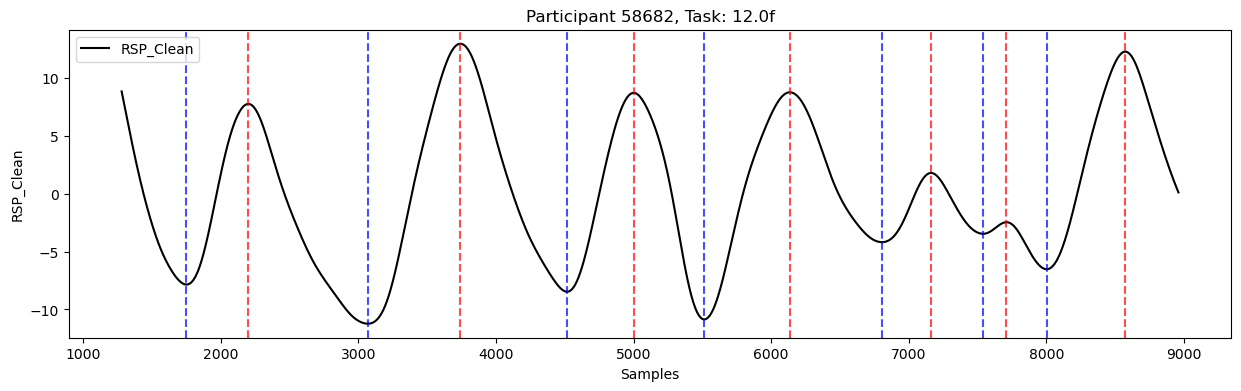

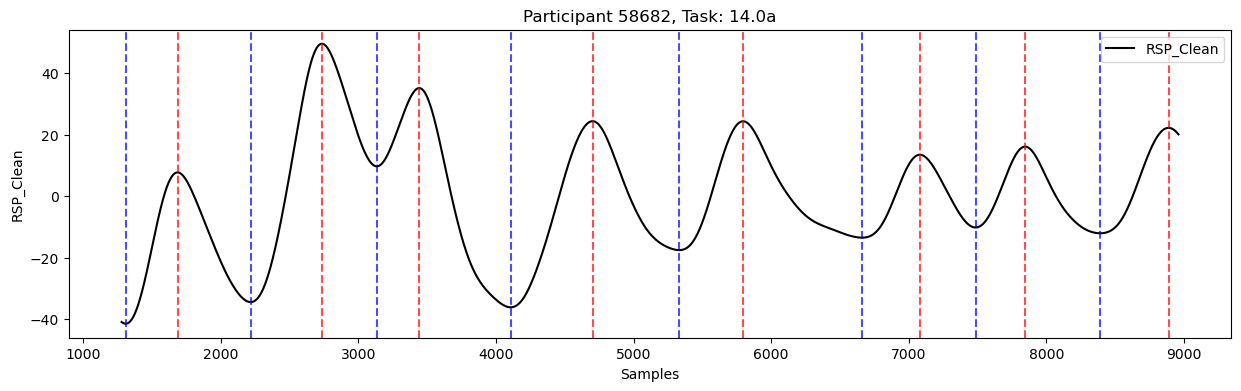

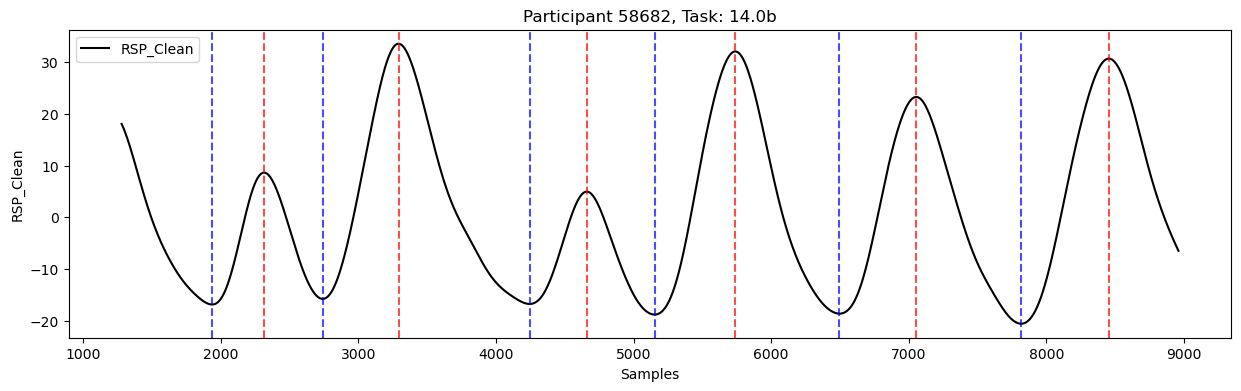

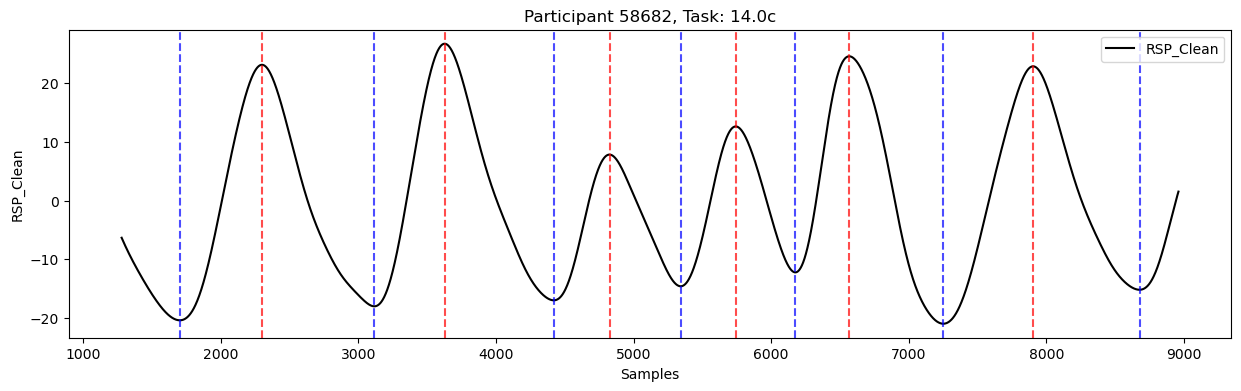

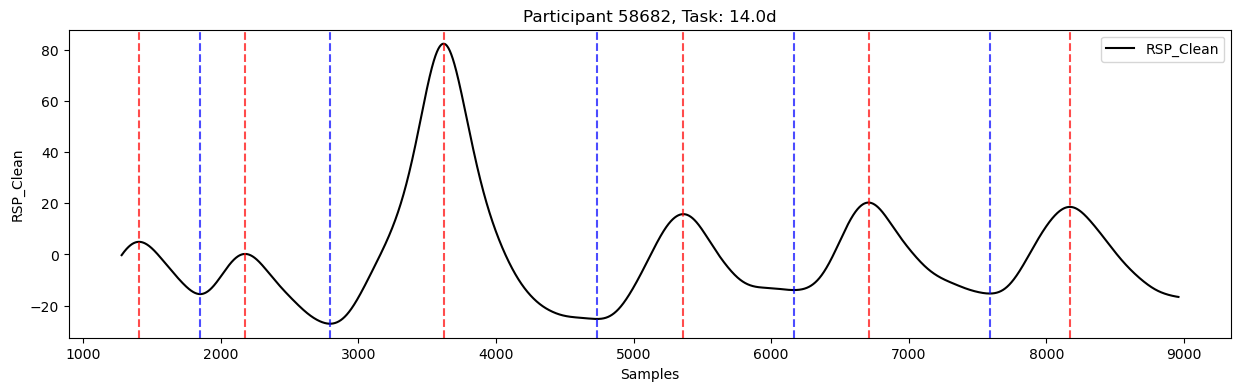

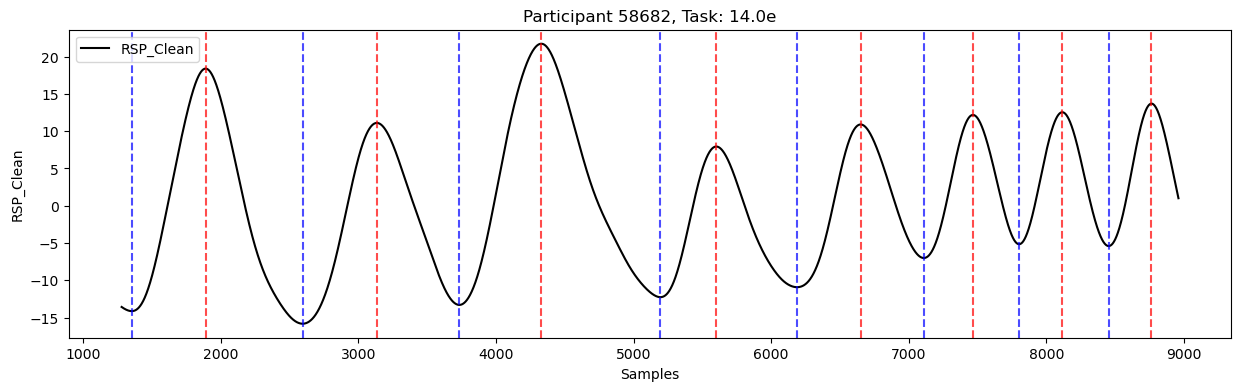

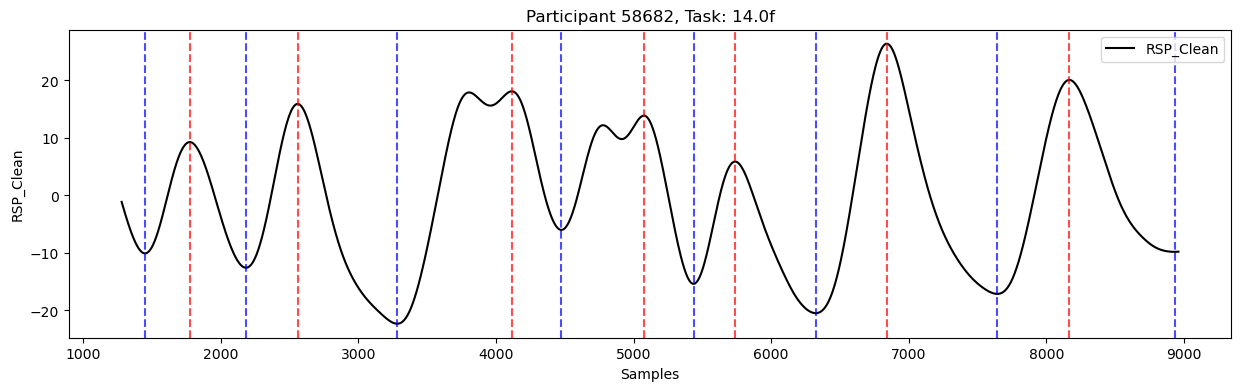

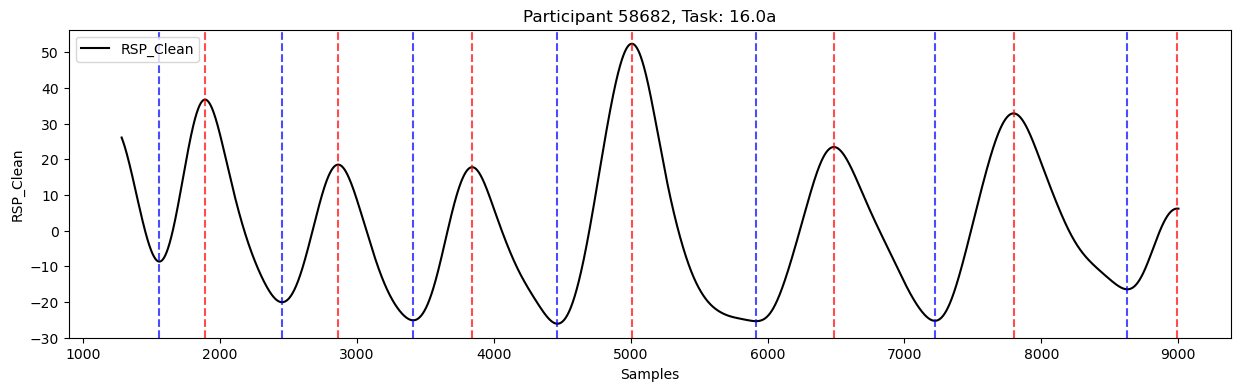

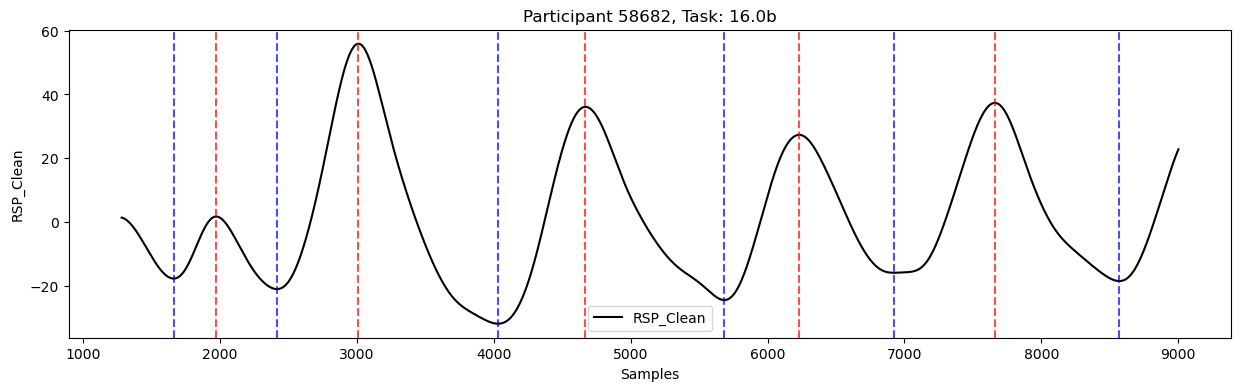

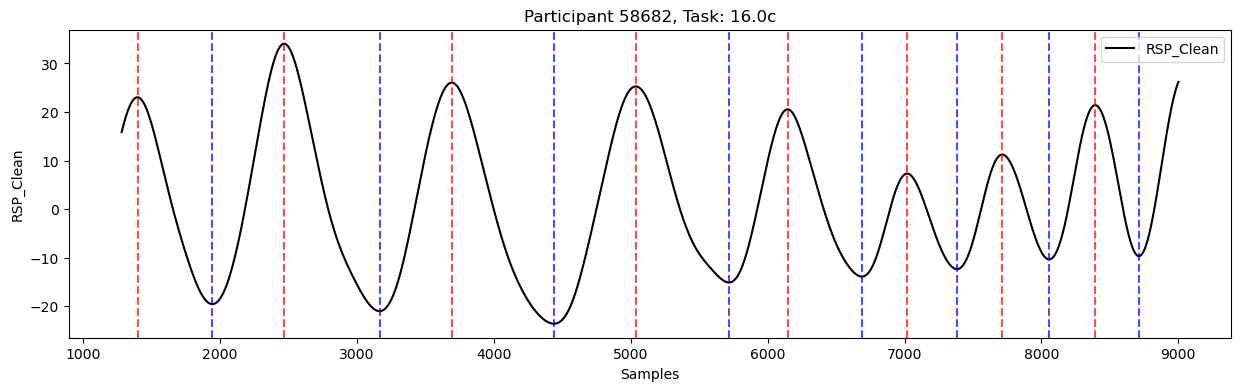

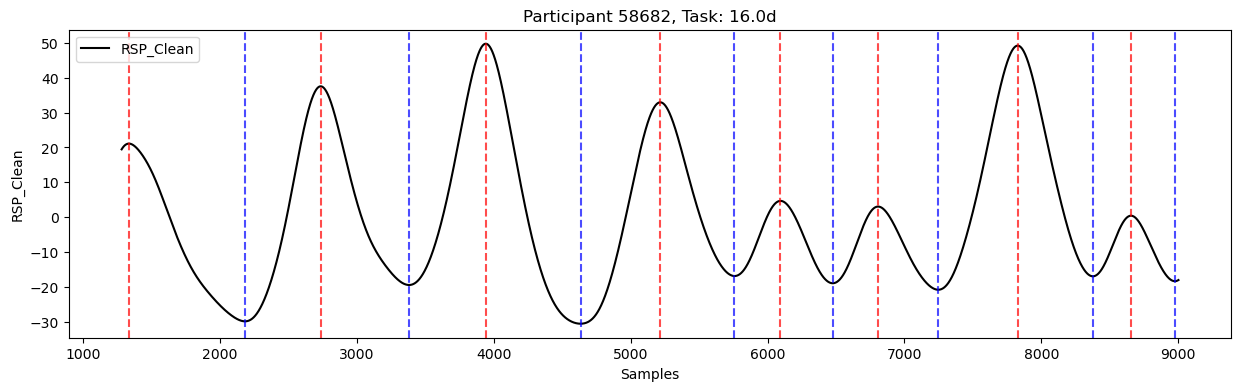

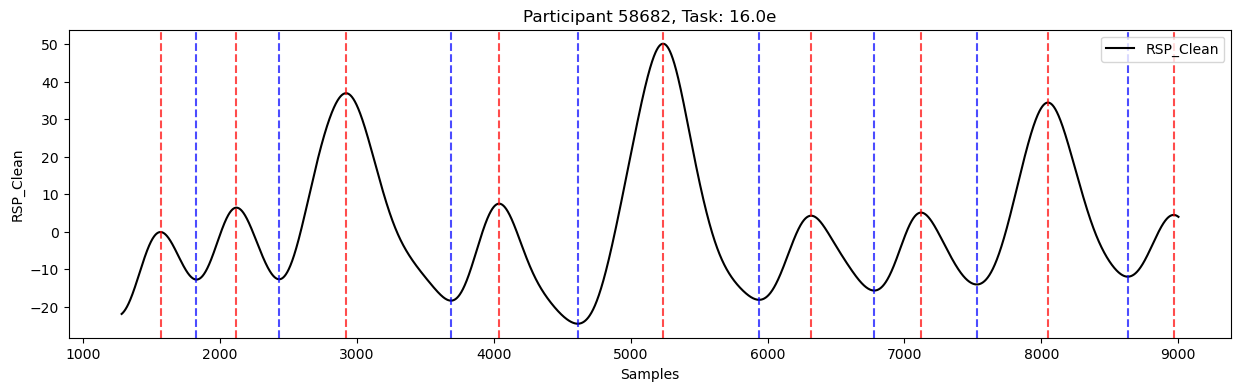

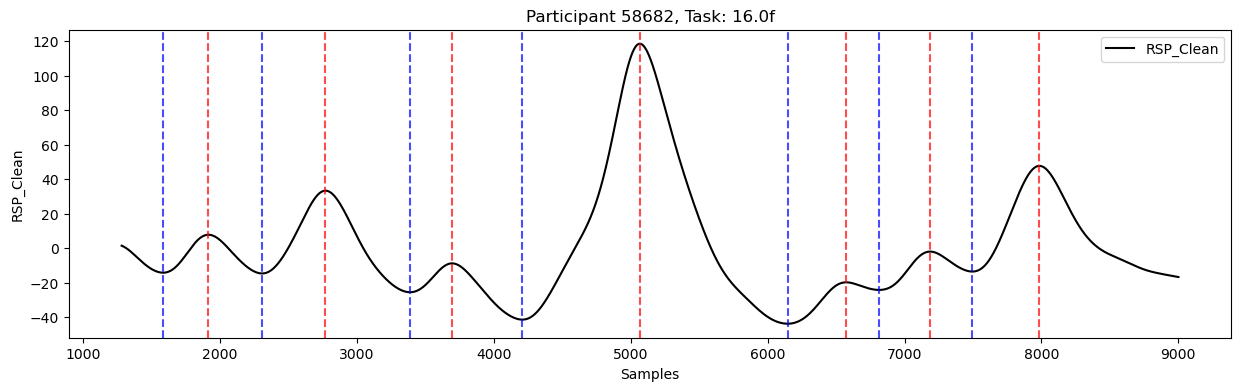

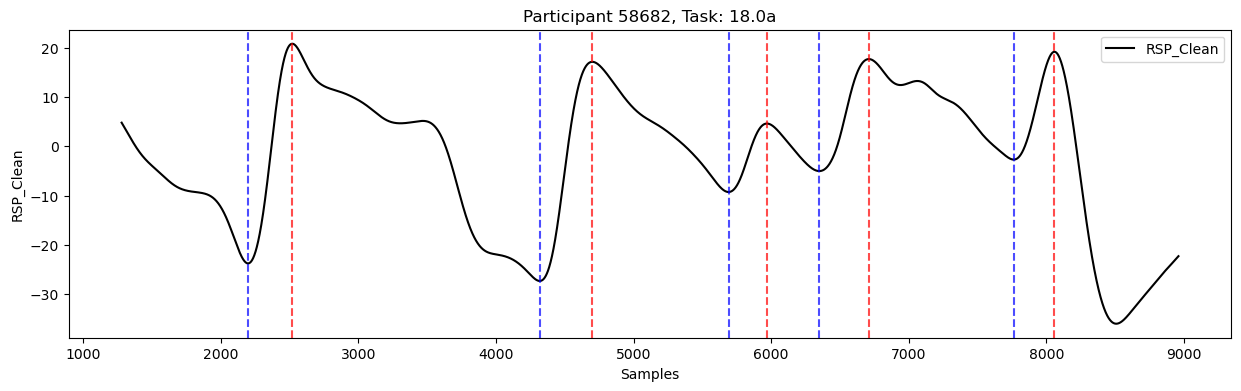

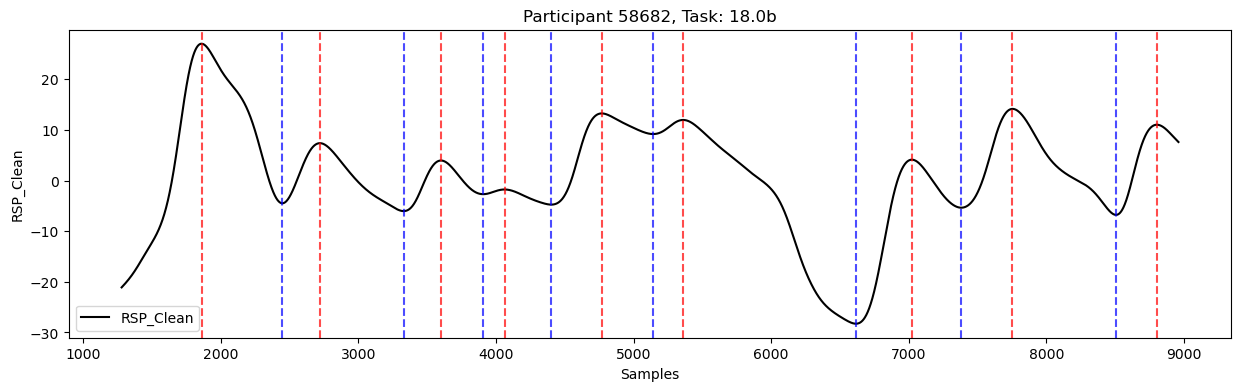

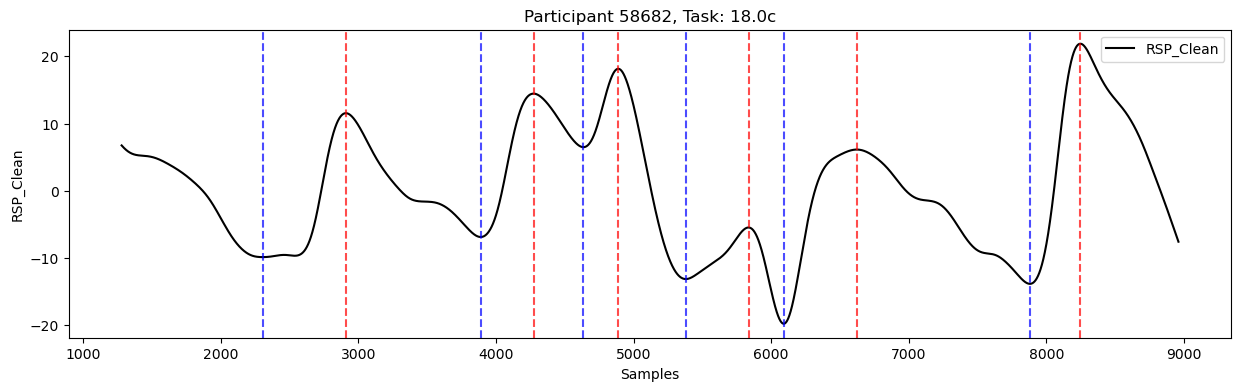

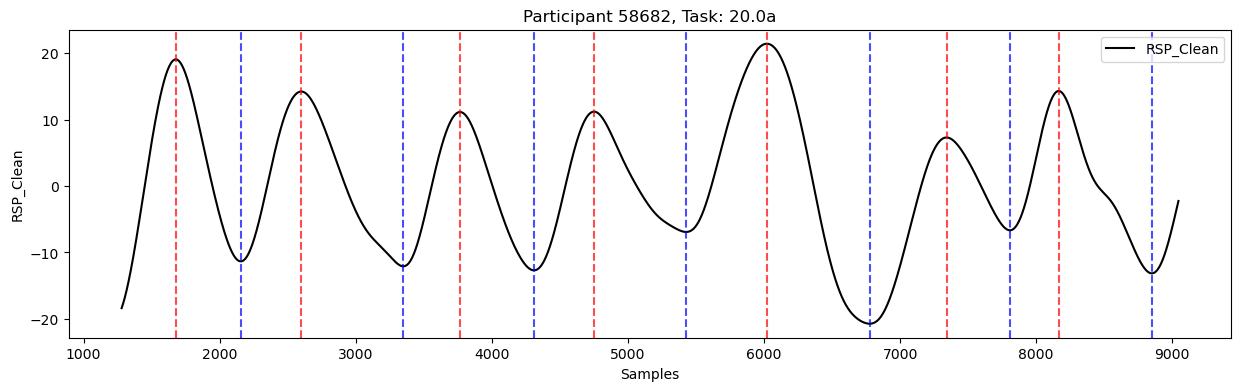

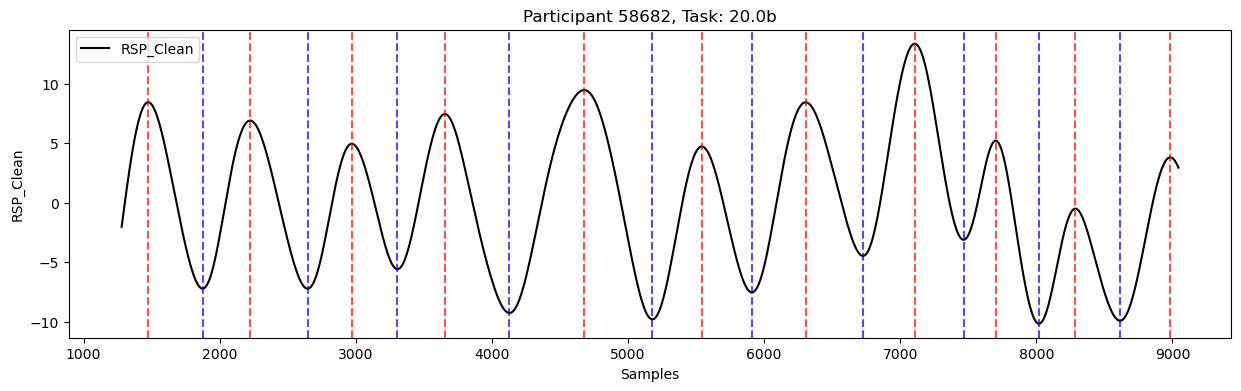

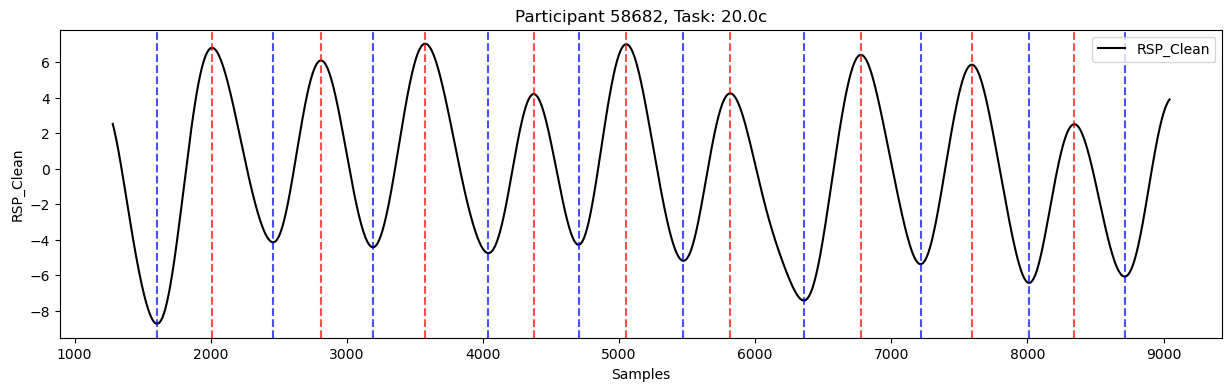

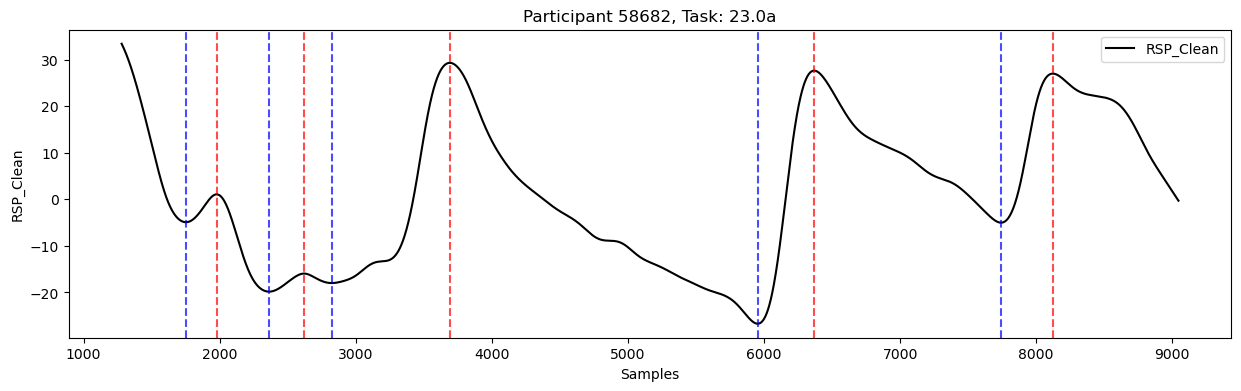

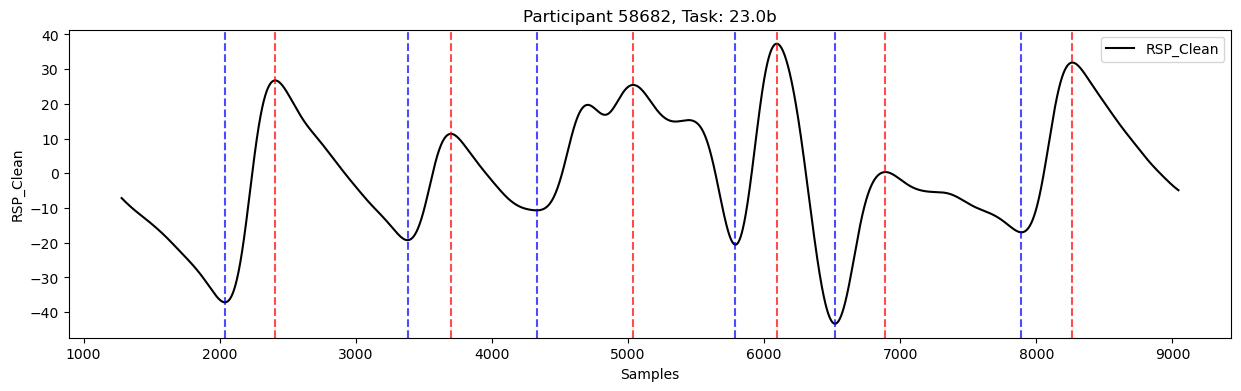

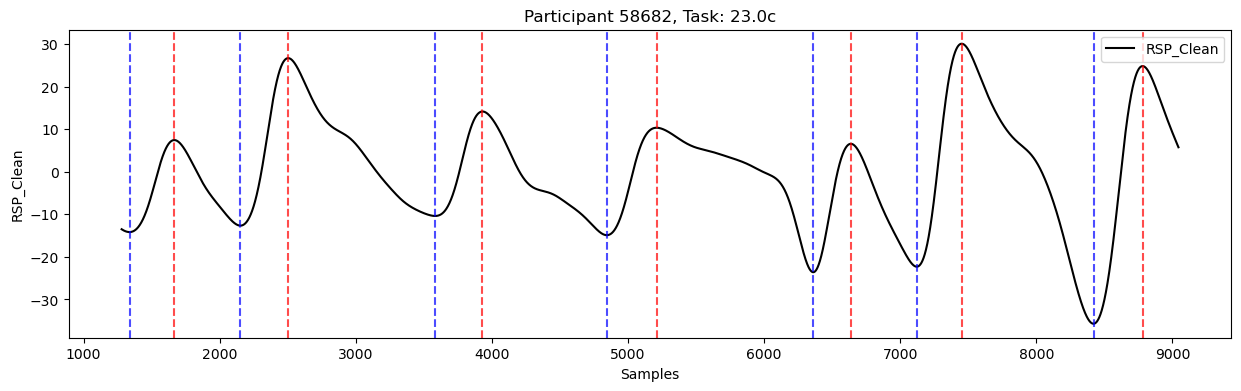

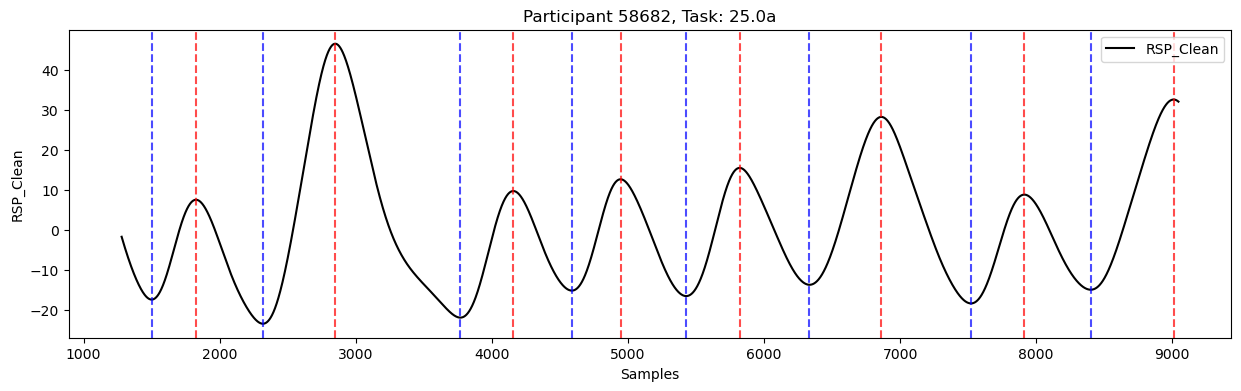

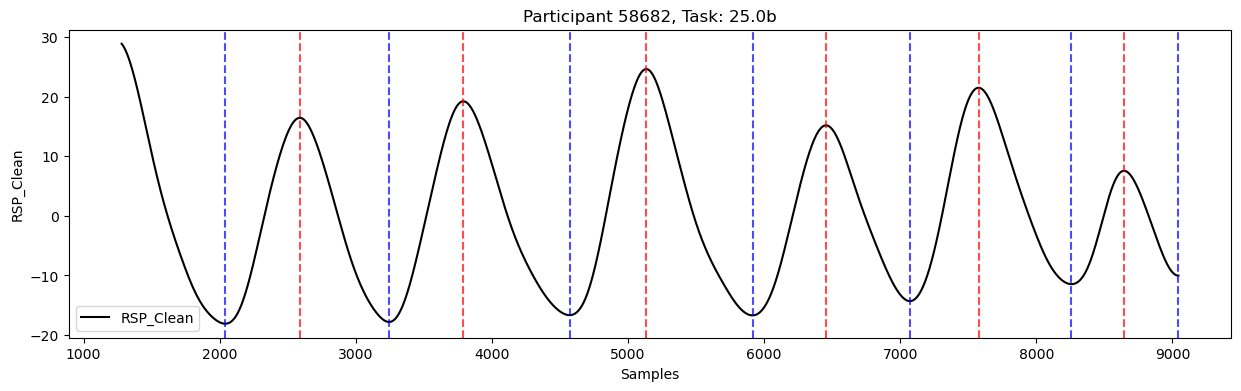

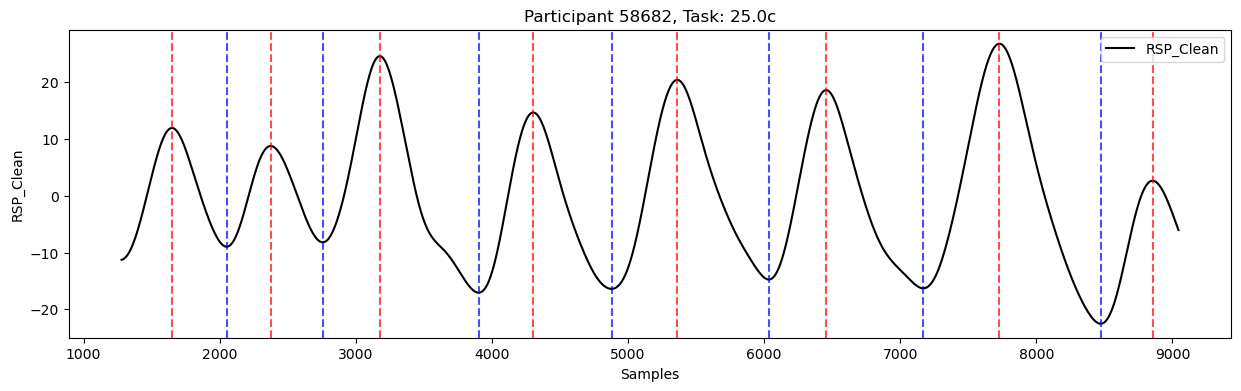

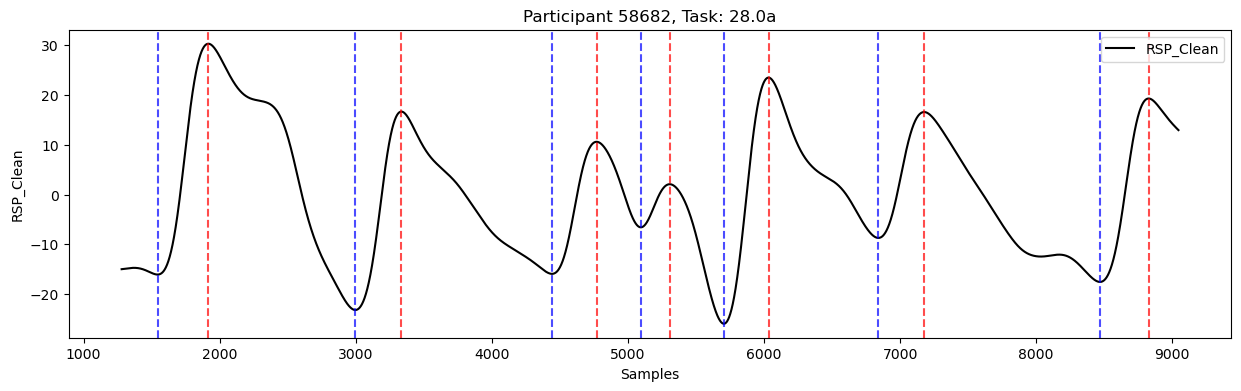

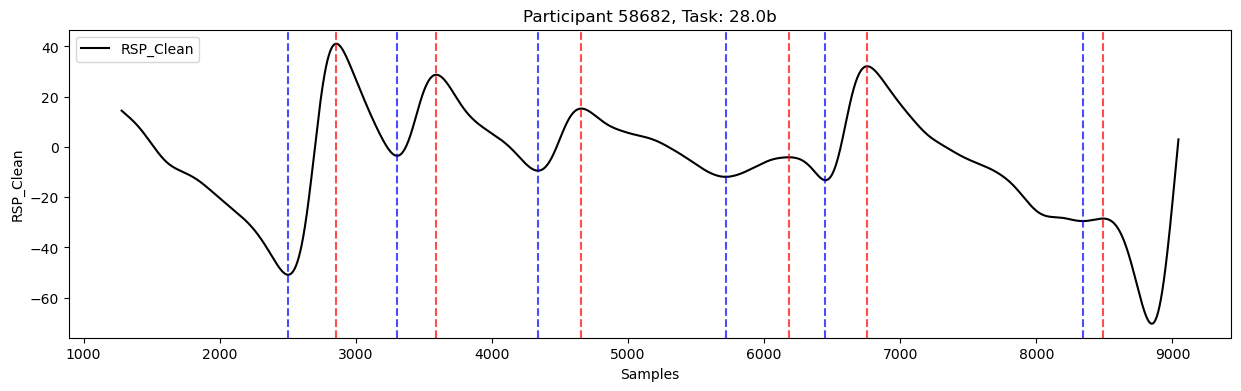

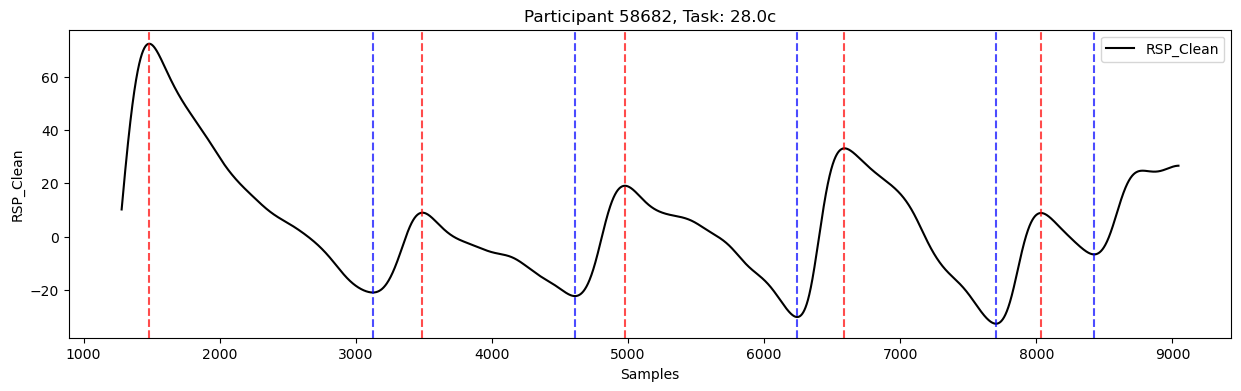

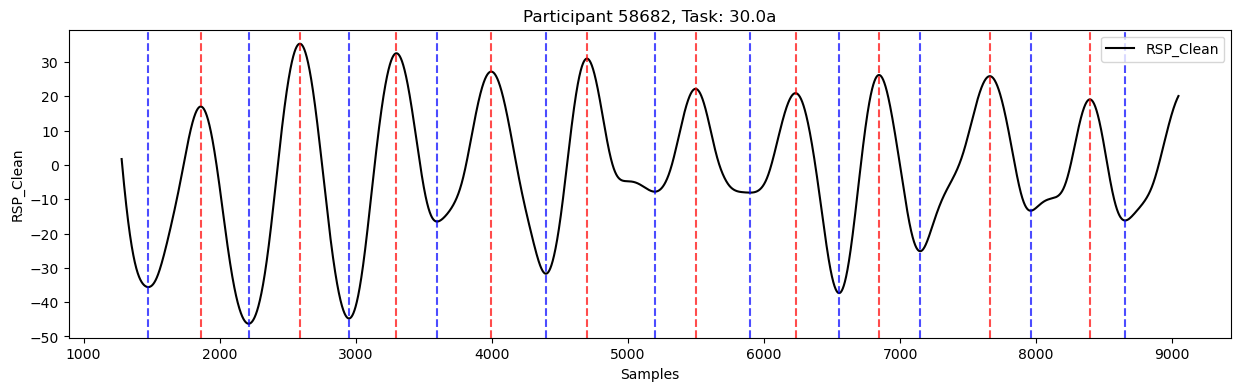

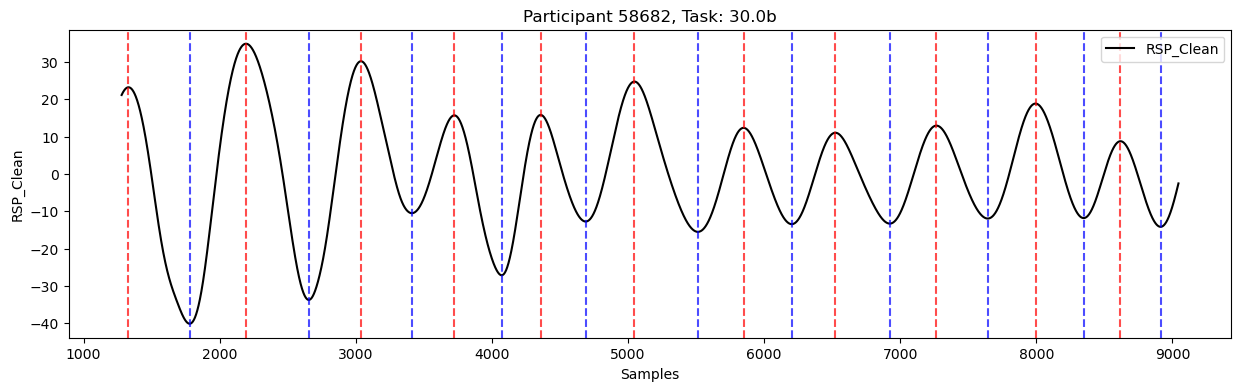

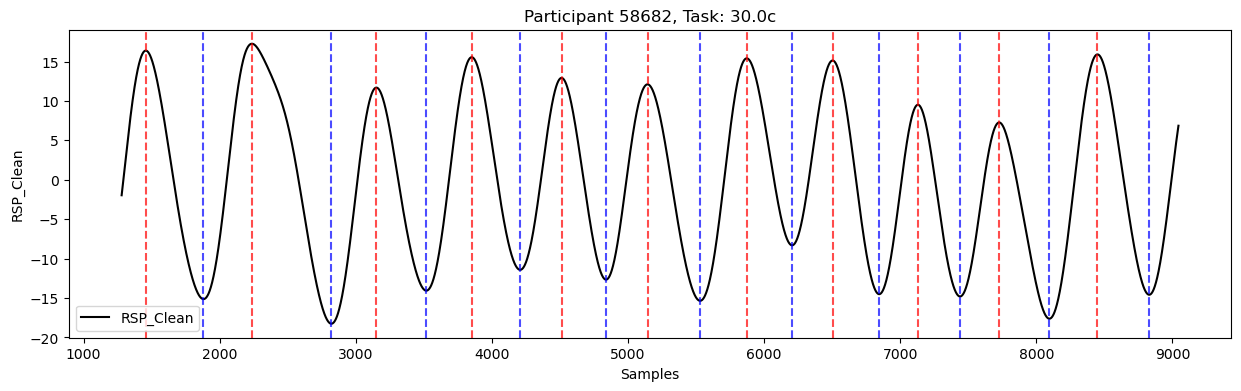

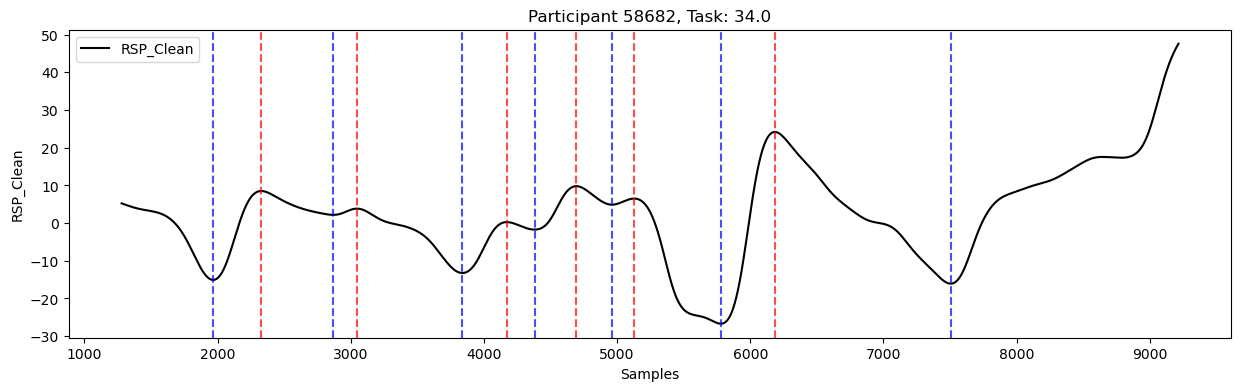

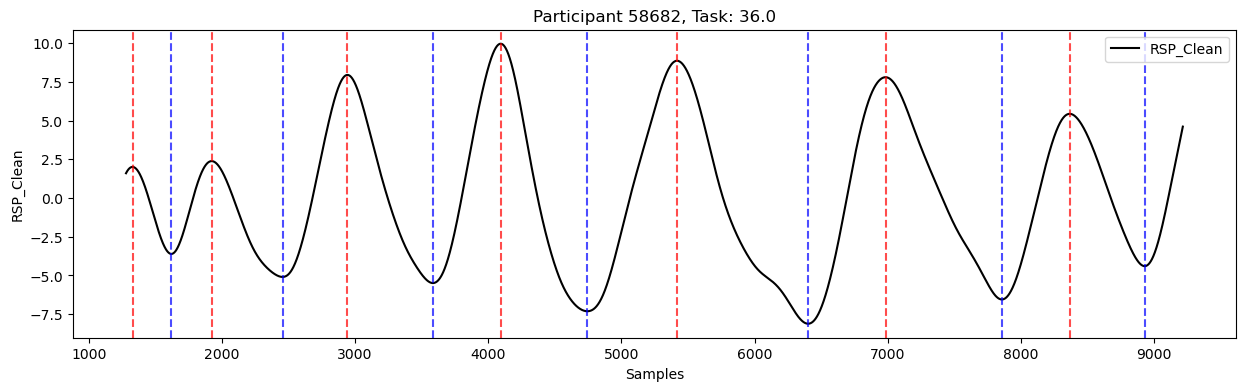

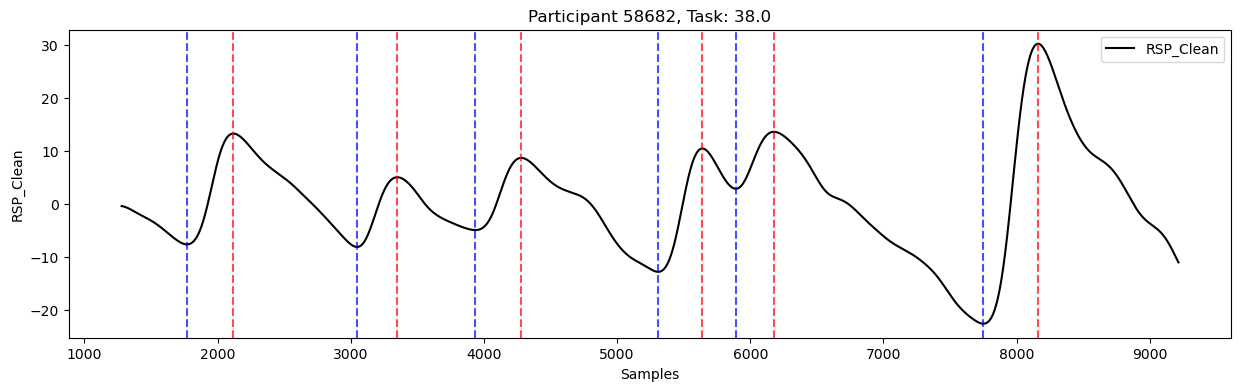

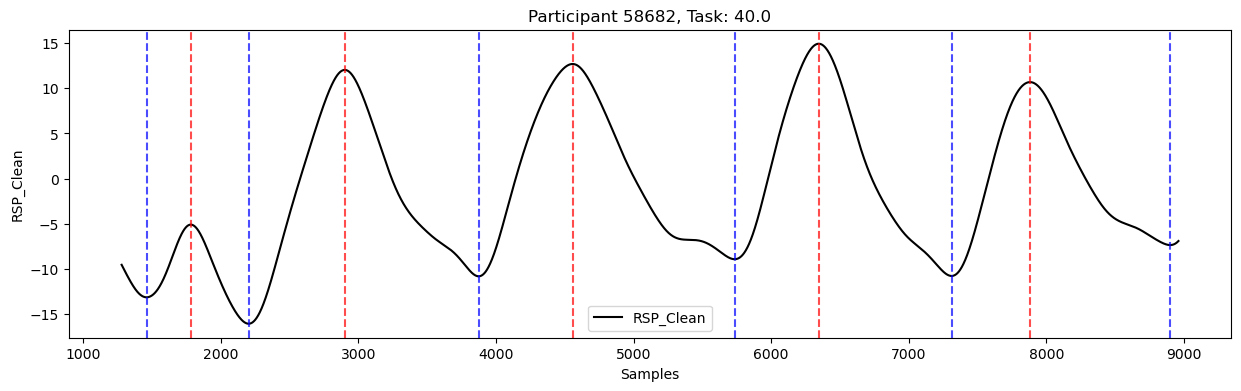

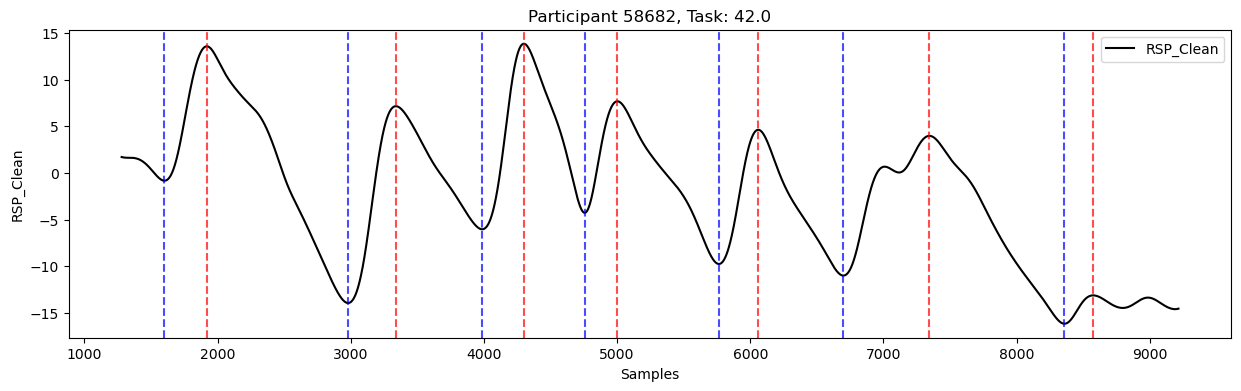

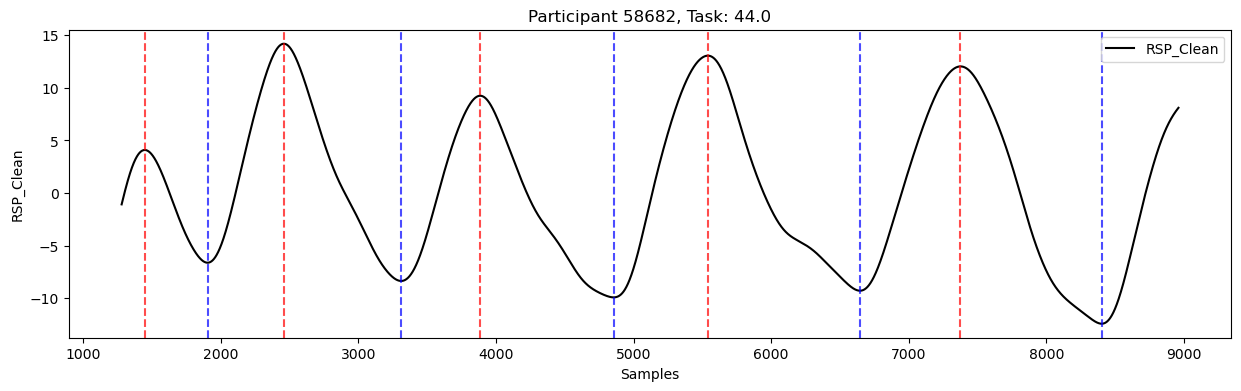

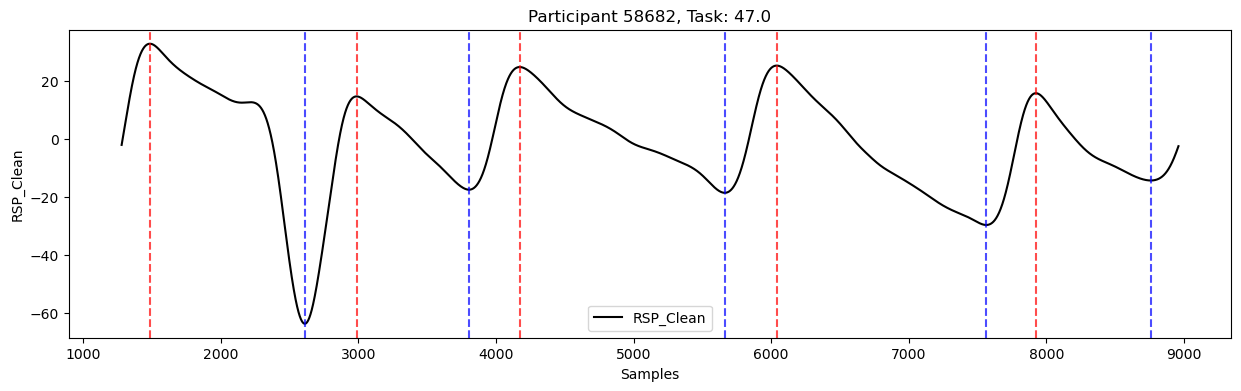

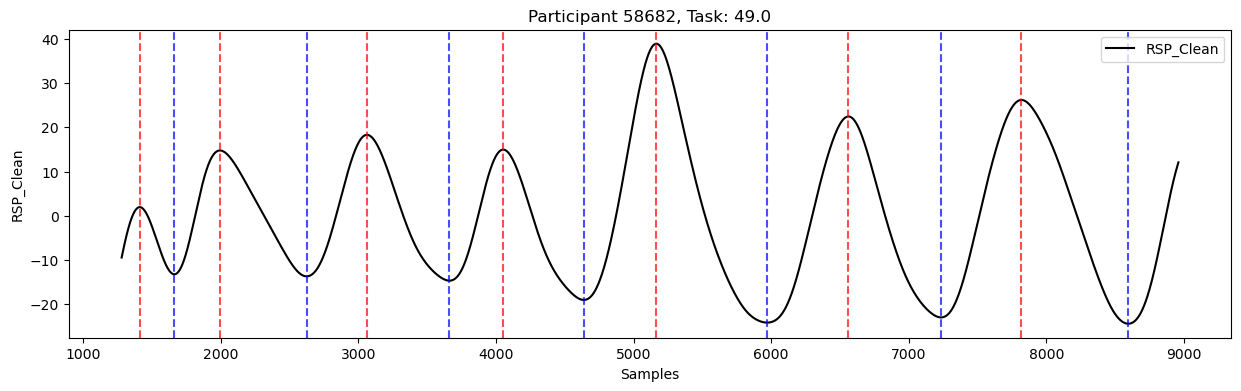

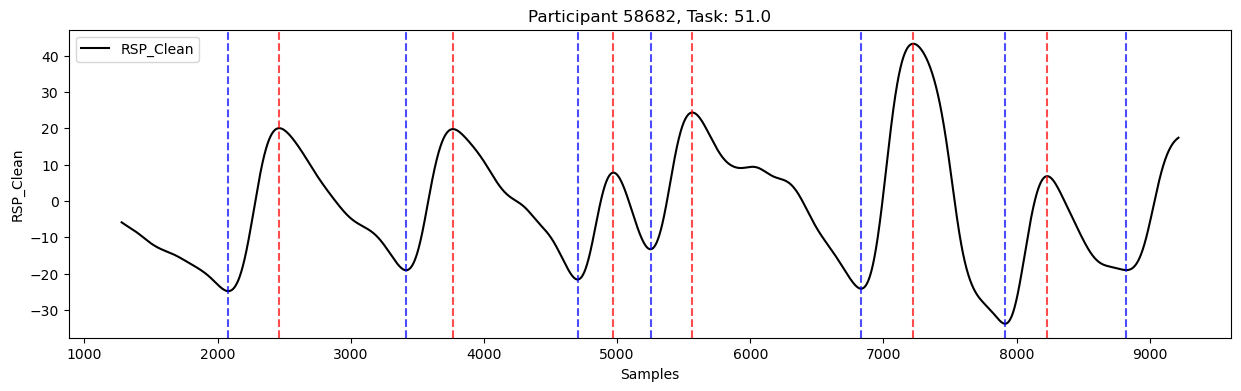

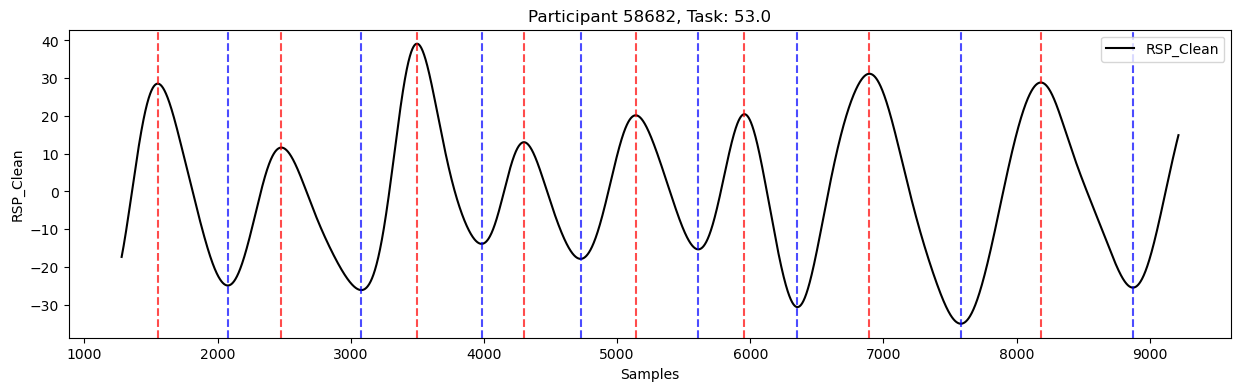

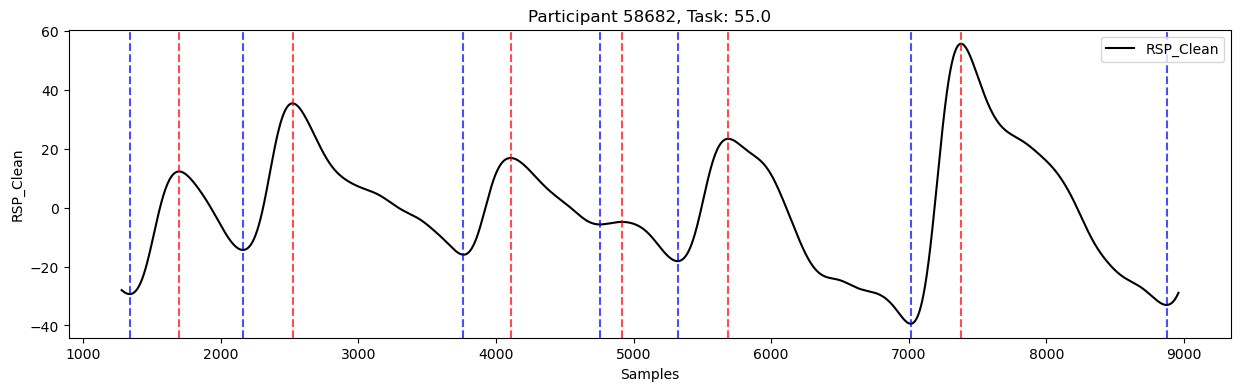

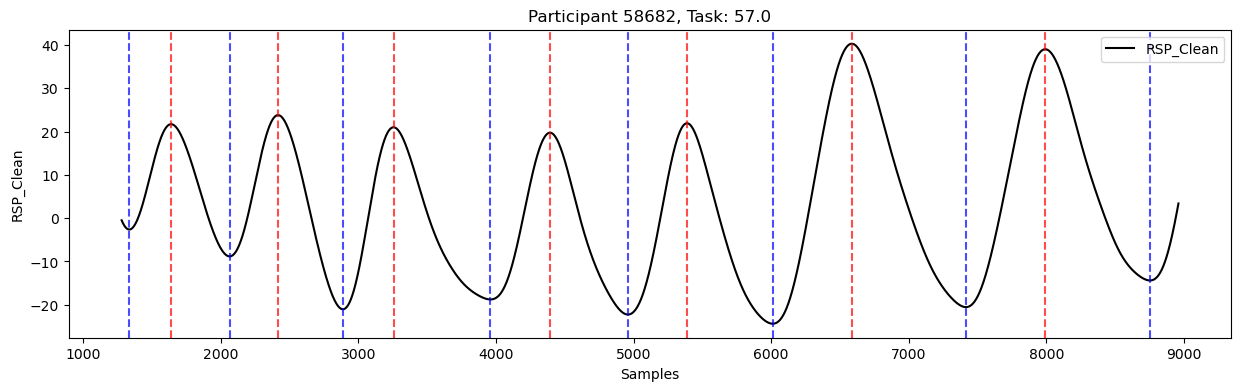

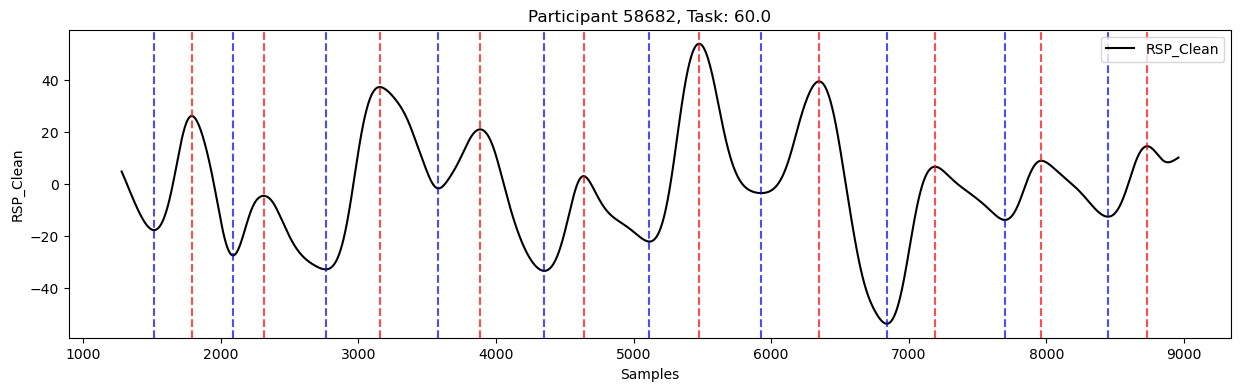

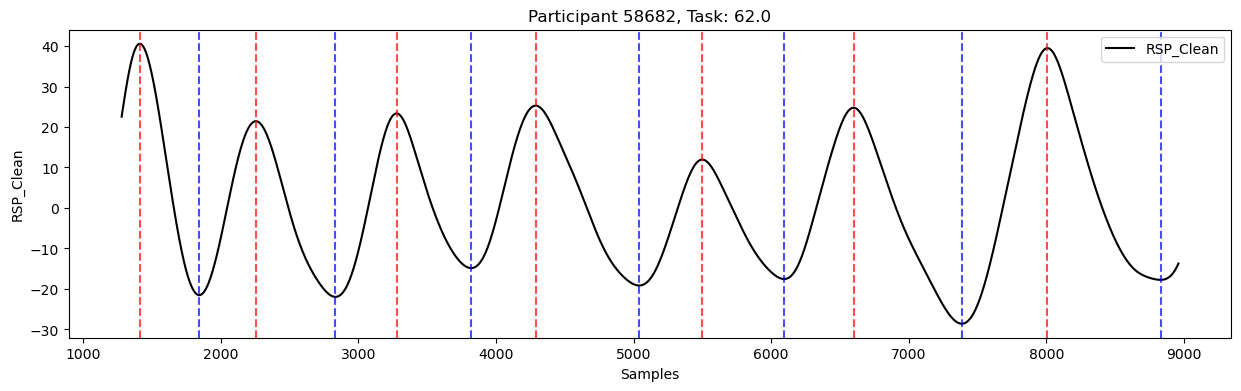

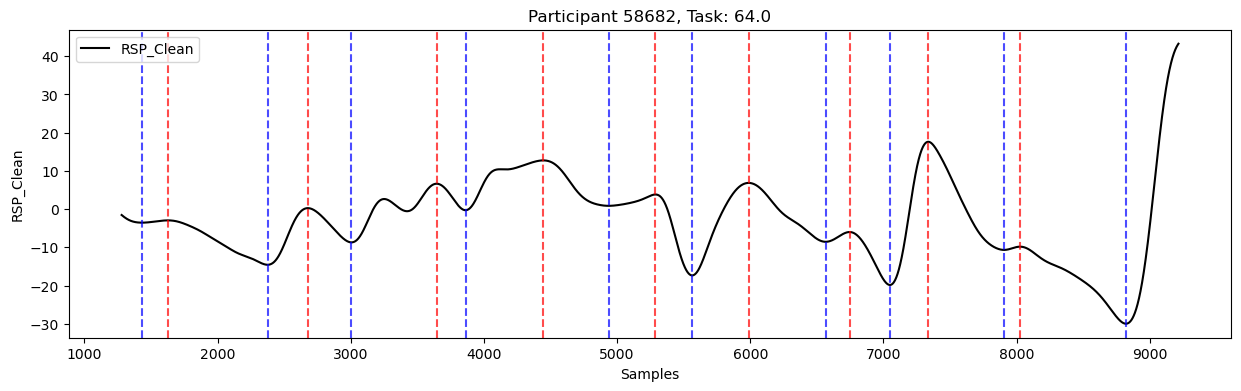

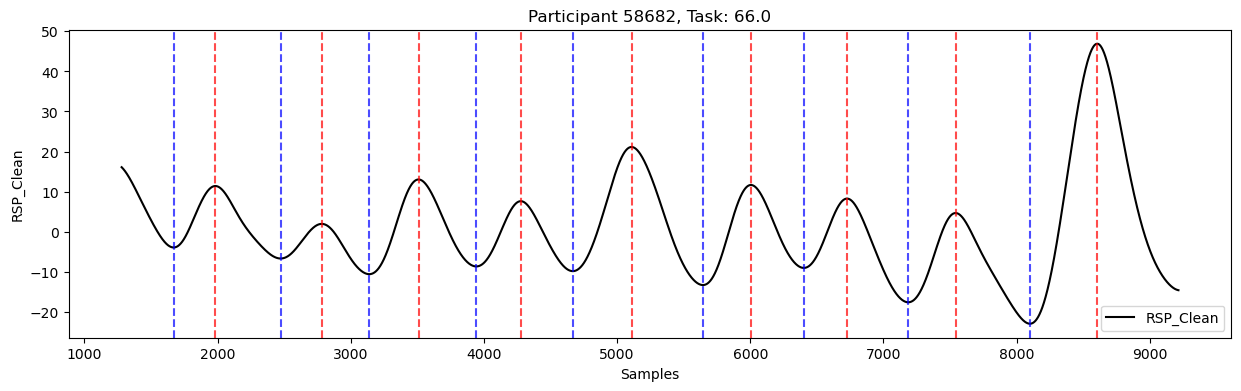

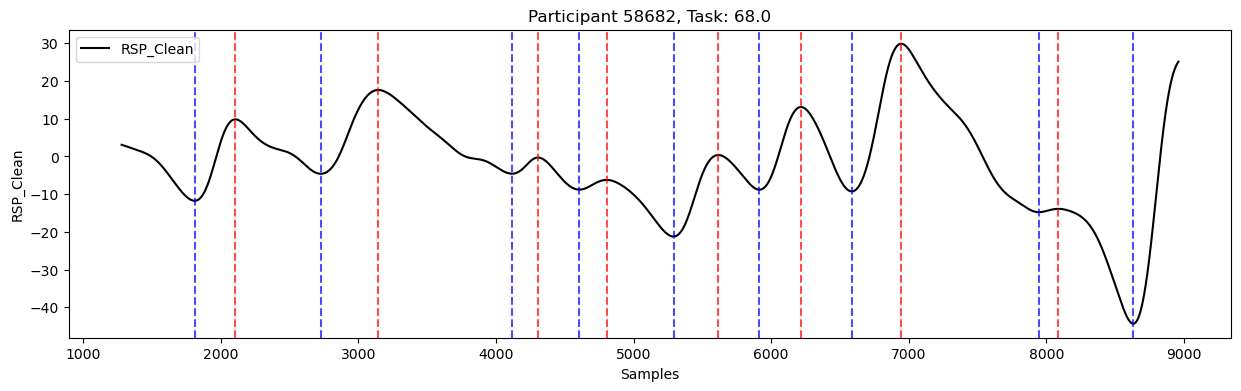

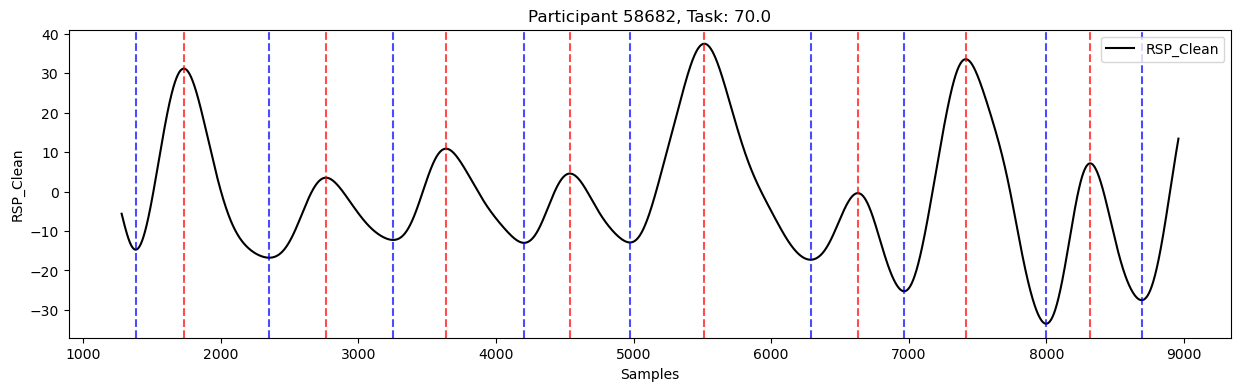

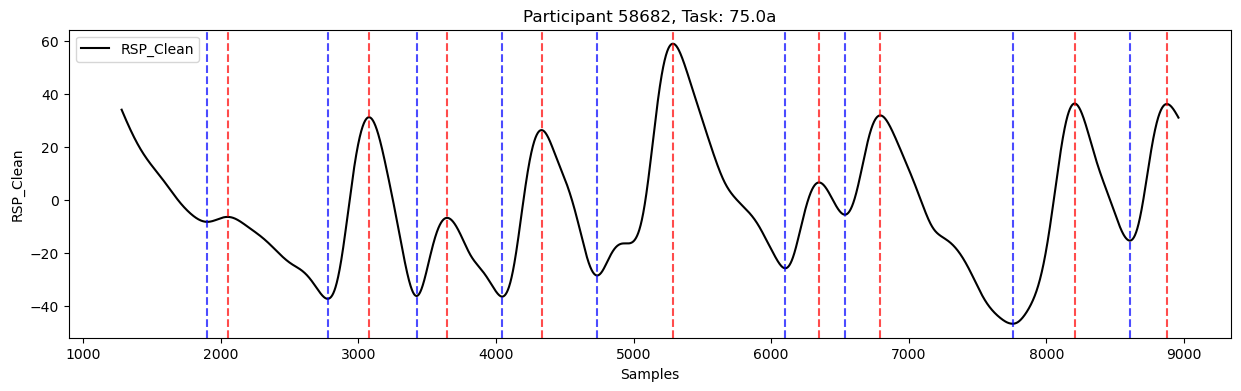

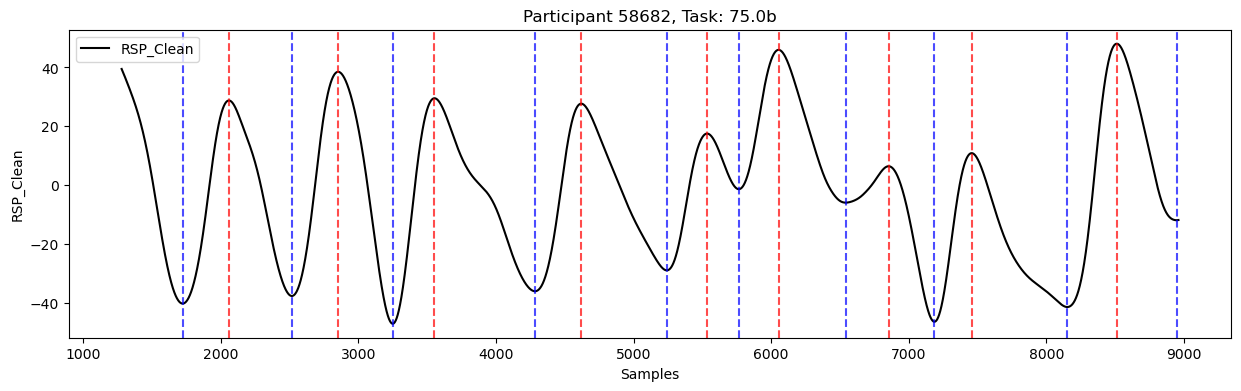

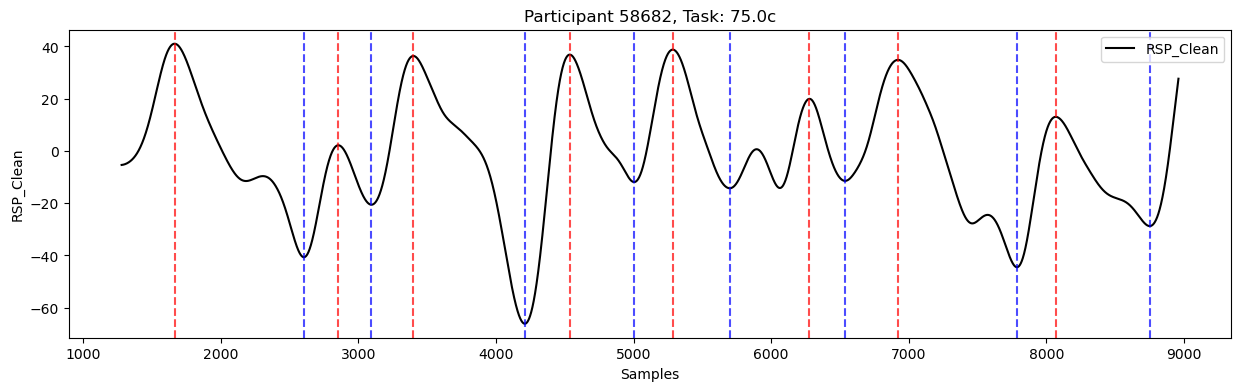

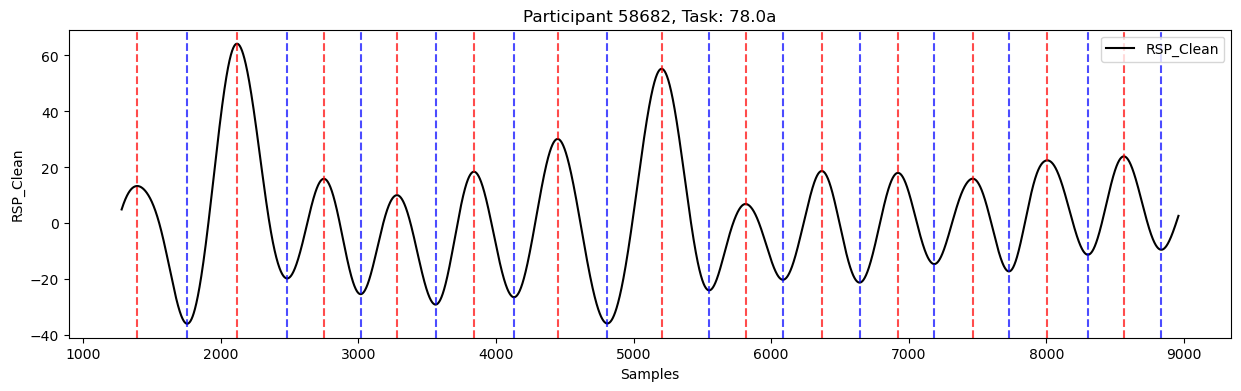

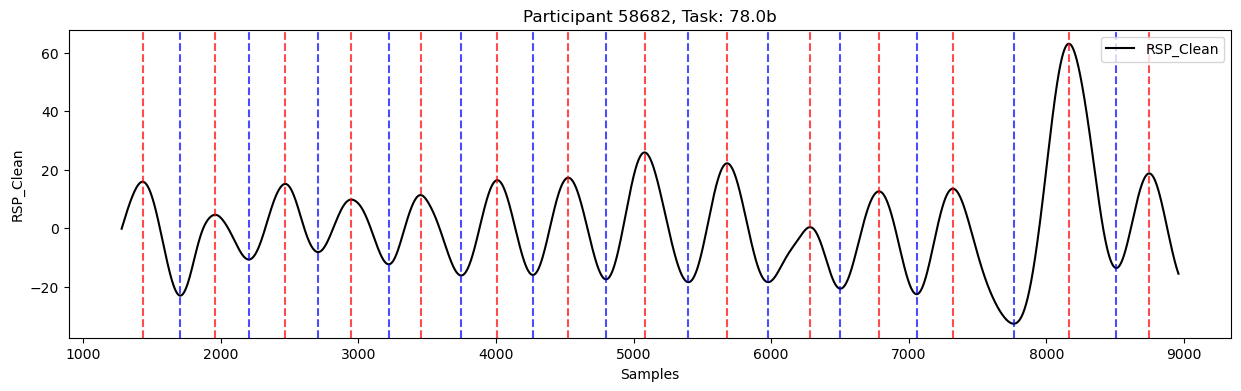

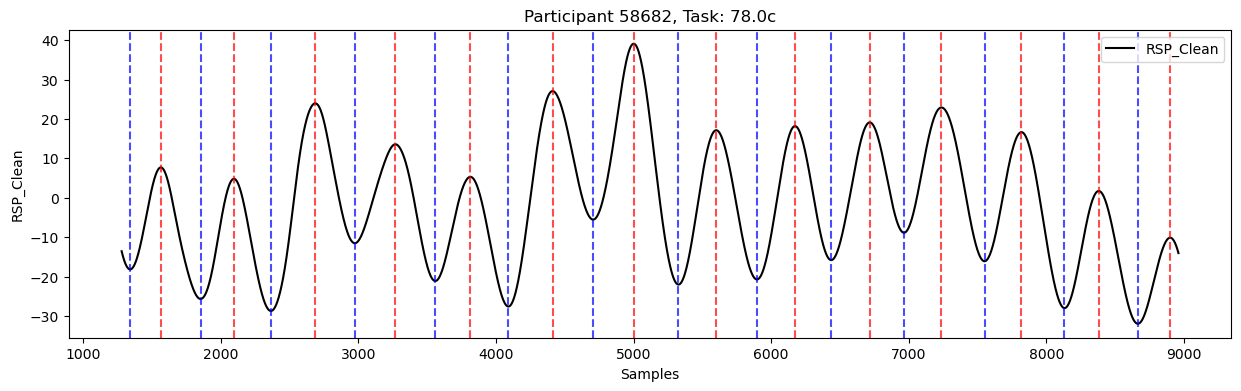

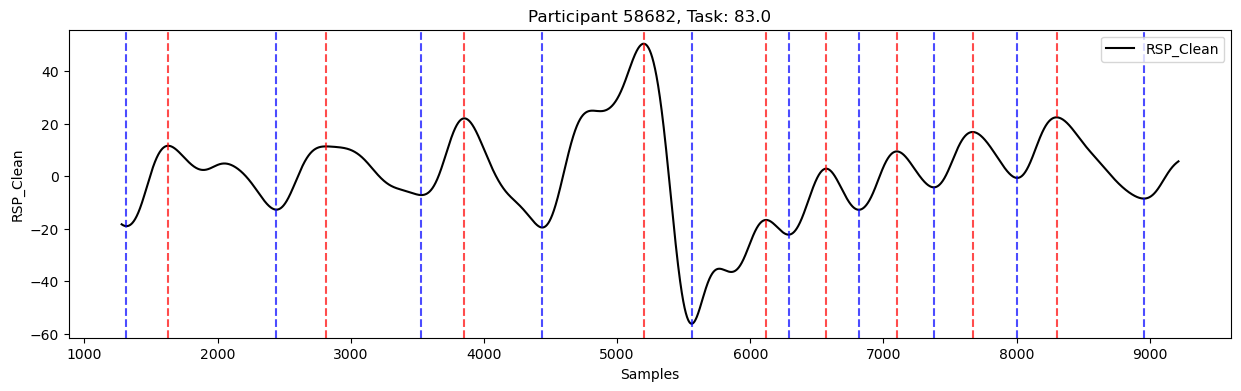

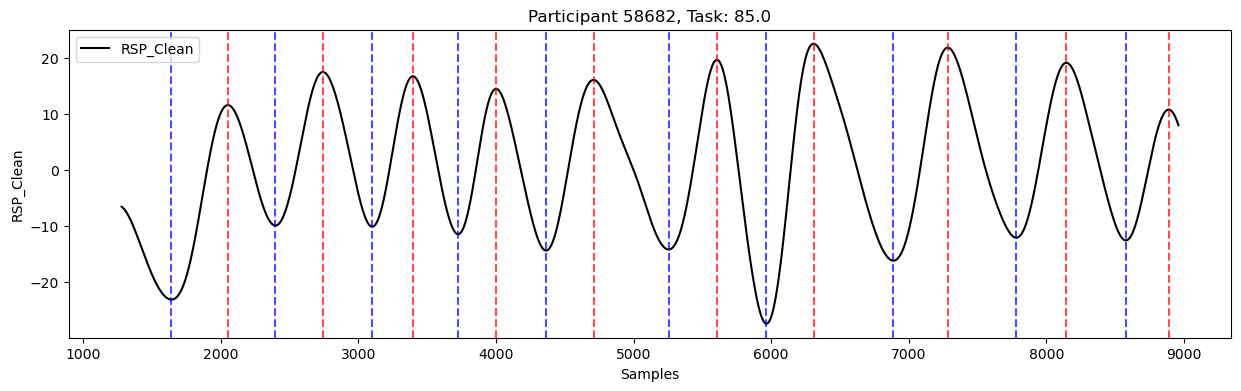

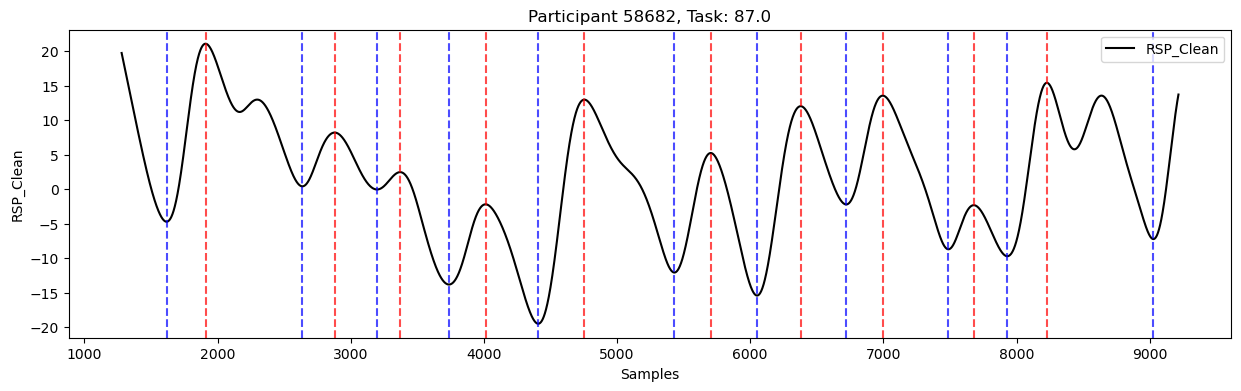

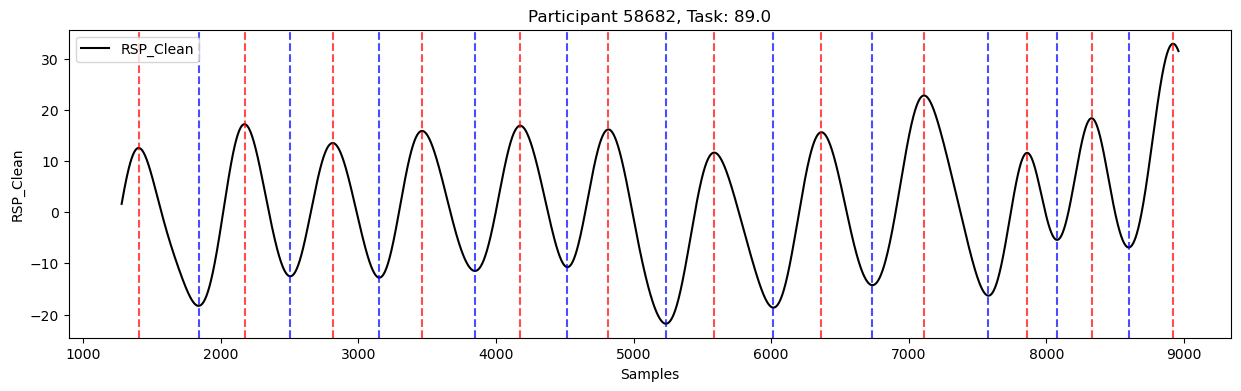

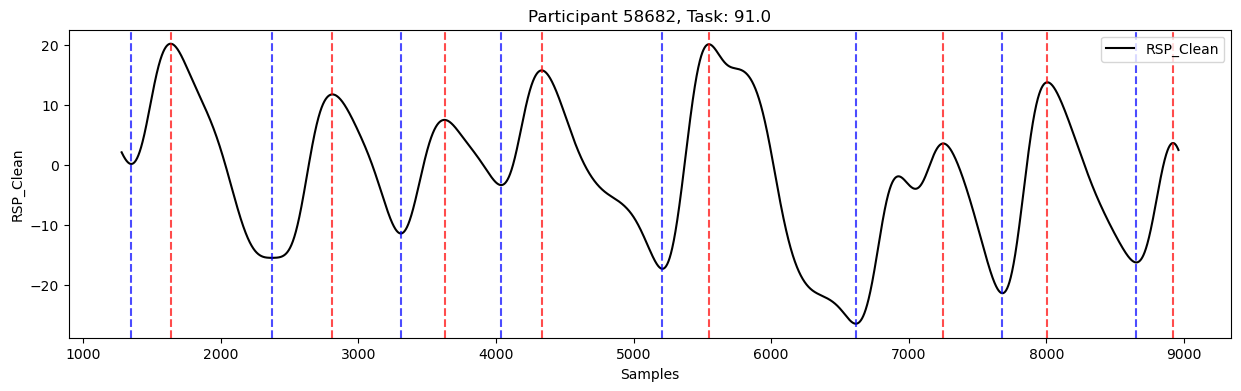

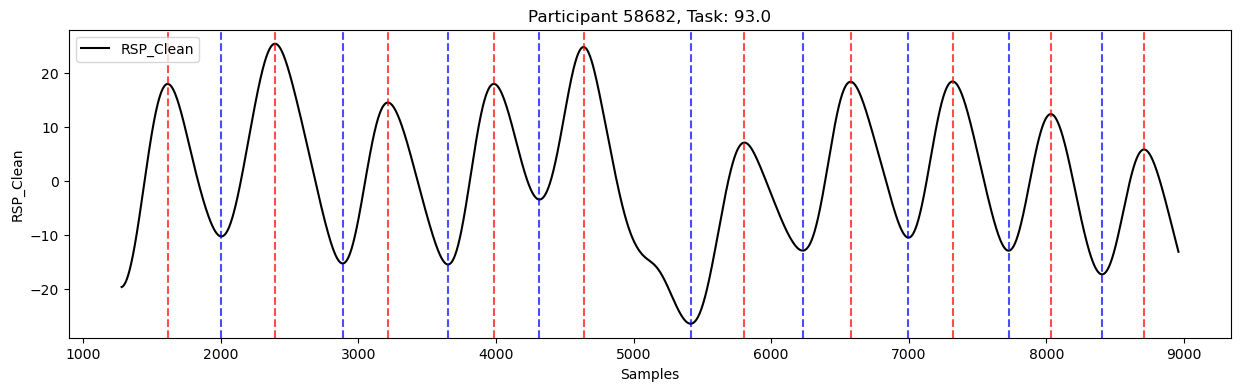

In [4]:
#let's run the function for the dataset we just uploaded
import neurokit2 as nk
import matplotlib.pyplot as plt

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

all_processed_data = {}

all_processed_data = process_and_visualize(df_thorax, tasks)


In [5]:
all_processed_data #contains, for each segment of interest + 5 seconds before and after, the RSP_Clean, RSP_Peaks, RSP_Troughs
#prior to feature extraction, let's double-check the variable contains the dataframes

{'12.0a':             RSP_Raw  RSP_Clean  RSP_Amplitude   RSP_Rate   RSP_RVT  RSP_Phase  \
 0     -23882.000000  -4.146147      20.623226  13.134620  7.461490        NaN   
 1     -23886.458728  -4.008757      20.623226  13.134620  7.461428        NaN   
 2     -23881.000000  -3.870629      20.623226  13.134620  7.461401        NaN   
 3     -23877.787623  -3.731778      20.623226  13.134620  7.461410        NaN   
 4     -23880.000000  -3.592215      20.623226  13.134620  7.461455        NaN   
 ...             ...        ...            ...        ...       ...        ...   
 10235 -23853.513376  -0.007893      15.213575  19.844961  5.400401        NaN   
 10236 -23852.000000  -0.006615      15.213575  19.844961  5.400021        NaN   
 10237 -23849.344781  -0.005490      15.213575  19.844961  5.399629        NaN   
 10238 -23852.000000  -0.004508      15.213575  19.844961  5.399226        NaN   
 10239 -23861.553407  -0.003657      15.213575  19.844961  5.398811        NaN   
 
     

In [6]:
import numpy as np 
import pandas as pd
#this code extracts features that don't come from neurokit (all features except respiratory rate, RRV, and peak-trough symmtery)
processed_dataframes = all_processed_data
sampling_rate = 256  #if the sampling rate is different for your data, change
task_results = {}
bbb_results = {}

for task, df in processed_dataframes.items():
    print(f"Task: {task}")

    # filter each dataframe for the actual task duration
    task_specific_df = df[df['Task_Label_2'] == task]
    peaks = task_specific_df[task_specific_df['RSP_Peaks'] == 1].index
    troughs = task_specific_df[task_specific_df['RSP_Troughs'] == 1].index

    # combine peaks and troughs into one list and sort
    combined_data = [('Peak', index) for index in peaks] + [('Trough', index) for index in troughs]
    combined_data.sort(key=lambda x: x[1])

    # initialize lists to store durations, amplitudes, flow rates, I:E ratios, and duty cycles
    inspiratory_durations = []
    expiratory_durations = []
    inspiratory_amplitudes = []
    expiratory_amplitudes = []
    inspiratory_flows = []
    expiratory_flows = []
    ie_ratios = []
    duty_cycles = []
    exp_diffs = []

    # iterate through combined data
    for i in range(1, len(combined_data)):
        current_type, current_index = combined_data[i]
        prev_type, prev_index = combined_data[i-1]

        # calculate duration and amplitude
        duration = (current_index - prev_index) / sampling_rate
        amplitude = abs(df.loc[current_index, 'RSP_Clean'] - df.loc[prev_index, 'RSP_Clean'])

        # calculate inspiratory duration, amplitude, and flow rate
        if current_type == 'Peak' and prev_type == 'Trough':
            inspiratory_durations.append(duration)
            inspiratory_amplitudes.append(amplitude)
            if duration > 0:
                inspiratory_flows.append(amplitude / duration)

        # calculate expiratory duration, amplitude, and flow rate
        elif current_type == 'Trough' and prev_type == 'Peak':
            expiratory_durations.append(duration)
            expiratory_amplitudes.append(amplitude)
            if duration > 0:
                expiratory_flows.append(amplitude / duration)
            if inspiratory_durations:
                ie_ratios.append(inspiratory_durations[-1] / duration)
                # Ensure duty cycle is calculated within each breath cycle
                total_cycle_duration = inspiratory_durations[-1] + expiratory_durations[-1]
                duty_cycle = inspiratory_durations[-1] / total_cycle_duration
                duty_cycles.append(duty_cycle)

    # calculate first-order exhalatory differences
    if len(expiratory_durations) > 1:
        exp_diffs = [abs(expiratory_durations[i] - expiratory_durations[i - 1]) for i in range(1, len(expiratory_durations))]

    # calculate mean and SD for durations, amplitudes, flow rates, I:E ratios, and duty cycles
    insp_dur_mean, insp_dur_sd = np.mean(inspiratory_durations), np.std(inspiratory_durations)
    exp_dur_mean, exp_dur_sd = np.mean(expiratory_durations), np.std(expiratory_durations)
    insp_amp_mean, insp_amp_sd = np.mean(inspiratory_amplitudes), np.std(inspiratory_amplitudes)
    exp_amp_mean, exp_amp_sd = np.mean(expiratory_amplitudes), np.std(expiratory_amplitudes)
    insp_flow_mean, insp_flow_sd = np.mean(inspiratory_flows), np.std(inspiratory_flows)
    exp_flow_mean, exp_flow_sd = np.mean(expiratory_flows), np.std(expiratory_flows)
    ie_ratio_mean, ie_ratio_sd = np.mean(ie_ratios), np.std(ie_ratios)
    duty_cycle_mean = np.mean(duty_cycles)
    exp_diff_mean = np.mean(exp_diffs) if exp_diffs else 0

    task_results[task] = {
        'insp_dur_mean': insp_dur_mean,
        'insp_dur_sd': insp_dur_sd,
        'exp_dur_mean': exp_dur_mean,
        'exp_dur_sd': exp_dur_sd,
        'insp_amp_mean': insp_amp_mean,
        'insp_amp_sd': insp_amp_sd,
        'exp_amp_mean': exp_amp_mean,
        'exp_amp_sd': exp_amp_sd,
        'insp_flow_mean': insp_flow_mean,
        'insp_flow_sd': insp_flow_sd,
        'exp_flow_mean': exp_flow_mean,
        'exp_flow_sd': exp_flow_sd,
        'ie_ratio_mean': ie_ratio_mean,
        'ie_ratio_sd': ie_ratio_sd,
        'duty_cycle_mean': duty_cycle_mean,
        'exp_diff_mean': exp_diff_mean
    }

    # store the breath-by-breath results separately
    bbb_results[task] = {
        'inspiratory_durations': inspiratory_durations,
        'expiratory_durations': expiratory_durations,
        'inspiratory_amplitudes': inspiratory_amplitudes,
        'expiratory_amplitudes': expiratory_amplitudes,
        'inspiratory_flows': inspiratory_flows,
        'expiratory_flows': expiratory_flows,
        'ie_ratios': ie_ratios,
        'duty_cycles': duty_cycles,
        'exp_diffs': exp_diffs
    }

# convert the dictionary to a data frame for task_results
respiratory_analysis_df = pd.DataFrame.from_dict(task_results, orient='index')
respiratory_analysis_df.reset_index(inplace=True)
respiratory_analysis_df.rename(columns={'index': 'Task_Label'}, inplace=True)

# create a dataframe for bbb_results
bbb_dataframe = pd.DataFrame.from_dict(bbb_results, orient='index')
bbb_dataframe.reset_index(inplace=True)
bbb_dataframe.rename(columns={'index': 'Task_Label'}, inplace=True)

#display the dataframe containing the features
respiratory_analysis_df


Task: 12.0a
Task: 12.0b
Task: 12.0c
Task: 12.0d
Task: 12.0e
Task: 12.0f
Task: 14.0a
Task: 14.0b
Task: 14.0c
Task: 14.0d
Task: 14.0e
Task: 14.0f
Task: 16.0a
Task: 16.0b
Task: 16.0c
Task: 16.0d
Task: 16.0e
Task: 16.0f
Task: 18.0a
Task: 18.0b
Task: 18.0c
Task: 20.0a
Task: 20.0b
Task: 20.0c
Task: 23.0a
Task: 23.0b
Task: 23.0c
Task: 25.0a
Task: 25.0b
Task: 25.0c
Task: 28.0a
Task: 28.0b
Task: 28.0c
Task: 30.0a
Task: 30.0b
Task: 30.0c
Task: 34.0
Task: 36.0
Task: 38.0
Task: 40.0
Task: 42.0
Task: 44.0
Task: 47.0
Task: 49.0
Task: 51.0
Task: 53.0
Task: 55.0
Task: 57.0
Task: 60.0
Task: 62.0
Task: 64.0
Task: 66.0
Task: 68.0
Task: 70.0
Task: 75.0a
Task: 75.0b
Task: 75.0c
Task: 78.0a
Task: 78.0b
Task: 78.0c
Task: 83.0
Task: 85.0
Task: 87.0
Task: 89.0
Task: 91.0
Task: 93.0


Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       2.104818     0.298978      2.397135    0.452415   
1       12.0b       2.127344     0.262732      2.643229    0.334577   
2       12.0c       2.248438     0.416243      2.950781    0.647069   
3       12.0d       2.440430     0.032374      3.410938    0.312562   
4       12.0e       2.077474     0.516745      2.718099    0.751587   
..        ...            ...          ...           ...         ...   
61       85.0       1.342188     0.153483      1.653646    0.349623   
62       87.0       1.051172     0.202865      1.843359    0.716086   
63       89.0       1.246449     0.130073      1.422585    0.277715   
64       91.0       1.417480     0.445486      2.603795    0.886095   
65       93.0       1.321181     0.119278      1.758247    0.481216   

    insp_amp_mean  insp_amp_sd  exp_amp_mean  exp_amp_sd  insp_flow_mean  \
0       23.780599     4.173396     22.869806    5.020956       11.262953   
1       22.487790     2.793519     21.488141    2.451376       10.662221   
2       22.521672     4.150223     23.149807    4.260963       10.024119   
3       20.470568     2.002103     20.780319    1.153957        8.380104   
4       17.637050     4.915462     17.377173    4.332020        8.424644   
..            ...          ...           ...         ...             ...   
61      32.247088     7.310476     32.054816    6.959497       24.022386   
62      17.227634     9.640672     17.479357    5.711707       15.207475   
63      31.048324     4.921574     29.197925    5.703830       24.868608   
64      25.969348     7.087779     29.180616   10.347085       19.097911   
65      29.977349     3.837102     31.328262    9.027551       22.644150   

    insp_flow_sd  exp_flow_mean  exp_flow_sd  ie_ratio_mean  ie_ratio_sd  \
0       0.848400       9.551110     0.979628       0.890087     0.088627   
1       1.499115       8.181919     0.891791       0.787497     0.048460   
2       0.495014       7.952316     0.662459       0.799065     0.078060   
3       0.727669       6.149557     0.706368       0.744472     0.061442   
4       0.694535       6.490494     0.525280       0.804125     0.060463   
..           ...            ...          ...            ...          ...   
61      4.770034      19.938660     5.334365       0.849844     0.174115   
62      6.764460       9.814967     2.559688       0.626720     0.182049   
63      2.622242      20.633653     1.981155       0.918020     0.150097   
64      5.449124      11.234448     2.330968       0.668281     0.387322   
65      1.620138      17.864908     2.541574       0.791244     0.163232   

    duty_cycle_mean  exp_diff_mean  
0          0.469717       0.445312  
1          0.440158       0.401562  
2          0.443108       0.841797  
3          0.426038       0.369141  
4          0.445059       0.904687  
..              ...            ...  
61         0.454662       0.396484  
62         0.377550       0.886719  
63         0.475656       0.289453  
64         0.372579       1.194010  
65         0.436385       0.543457  

[66 rows x 17 columns]

In [7]:
#we also need to add the features from neurokit2's function, below we run the intervalrelated function of neurokit2

import pandas as pd
import neurokit2 as nk

tasks = ['12.0a', '12.0b', '12.0c', '12.0d', '12.0e', '12.0f', '14.0a', '14.0b', '14.0c', '14.0d', '14.0e',
         '14.0f', '16.0a', '16.0b', '16.0c', '16.0d', '16.0e', '16.0f', '18.0a', '18.0b', '18.0c', '20.0a',
         '20.0b', '20.0c', '23.0a', '23.0b', '23.0c', '25.0a', '25.0b', '25.0c', '28.0a', '28.0b', '28.0c',
         '30.0a', '30.0b', '30.0c', 34.0, 36.0, 38.0, 40.0, 42.0, 44.0, 47.0, 49.0, 51.0, 53.0, 55.0, 57.0, 60.0,
         62.0, 64.0, 66.0, 68.0, 70.0, '75.0a', '75.0b', '75.0c', '78.0a', '78.0b', '78.0c', 83.0, 85.0, 87.0,
         89.0, 91.0, 93.0]

processed_dataframes = all_processed_data

# initializing empty list
interval_features_list = []

# iterating over task dataframes
for task, df in processed_dataframes.items():
    try:
        # filtering the dataframe for the actual task duration
        task_specific_df = df[df['Task_Label_2'] == task]

        # extracting interval-related features
        features_df = nk.rsp_intervalrelated(task_specific_df, sampling_rate=256)

        # adding a column for the task label
        features_df['Task_Label'] = task

        # appending the features DataFrame to the list
        interval_features_list.append(features_df)
    except Exception as e:
        print(f"Error processing task {task}: {e}")

# concatenating all feature dataframes
interval_features_df = pd.concat(interval_features_list, ignore_index=True)
interval_features_df

C:\Users\msa583\AppData\Local\anaconda3\lib\site-packages\neurokit2\rsp\rsp_rrv.py:213: RuntimeWarning: invalid value encountered in sqrt
  out["SD2"] = np.sqrt(2 * np.std(bbi, ddof=1) ** 2 - 0.5 * np.std(diff_bbi, ddof=1) ** 2)


RSP_Rate_Mean    RRV_RMSSD   RRV_MeanBB     RRV_SDBB     RRV_SDSD  \
0       12.719730   660.953199  4501.953125   785.778865   582.902295   
1       13.239173  1061.354075  4832.812500   648.604553  1225.338595   
2       11.848371  1994.745345  5099.609375  1298.891270  2442.966168   
3       10.287930   221.373314  5738.281250   243.715776   146.644877   
4       12.705959  1856.016572  4595.312500  1413.767342  1928.520478   
..            ...          ...          ...          ...          ...   
61      19.940293   551.040913  3009.982639   436.640789   588.679410   
62      20.996708  1341.034583  2894.531250   893.707355  1421.928656   
63      22.741308   499.438500  2640.234375   409.568652   525.512026   
64      15.072812  1040.636291  4075.334821   819.086119  1139.424177   
65      19.353718   804.947513  3124.511719   544.255675   860.875314   

    RRV_CVBB  RRV_CVSD  RRV_MedianBB    RRV_MadBB  RRV_MCVBB  ...     RAV_SD  \
0   0.174542  0.146815   4787.109375   434.355469   0.090734  ...   4.571727   
1   0.134209  0.219614   4621.093750   115.828125   0.025065  ...   3.814021   
2   0.254704  0.391156   5576.171875   608.097656   0.109053  ...   4.508996   
3   0.042472  0.038578   5673.828125   150.576562   0.026539  ...   2.038449   
4   0.307654  0.403893   5175.781250  1546.305469   0.298758  ...   5.291764   
..       ...       ...           ...          ...        ...  ...        ...   
61  0.145064  0.183071   2949.218750   671.803125   0.227790  ...   7.705918   
62  0.308757  0.463299   2615.234375   689.177344   0.263524  ...  10.162161   
63  0.155126  0.189164   2667.968750   205.594922   0.077060  ...   4.929551   
64  0.200986  0.255350   3992.187500   492.269531   0.123308  ...   7.577154   
65  0.174189  0.257623   2994.140625   393.815625   0.131529  ...   4.546508   

    RAV_RMSSD  RAV_CVSD    RSP_RVT  RSP_Symmetry_PeakTrough  \
0    4.881334  0.205265   4.975650                 0.518596   
1    6.264322  0.292347   4.573790                 0.498581   
2    6.977878  0.300237   4.321324                 0.488615   
3    2.772561  0.134317   3.401956                 0.495456   
4    7.263253  0.395219   3.690321                 0.511966   
..        ...       ...        ...                      ...   
61   8.165284  0.253210  10.479310                 0.509792   
62  14.054348  0.815803   5.173978                 0.448436   
63   6.985608  0.225579  11.255368                 0.514678   
64  10.478748  0.403504   6.065929                 0.501129   
65   3.887674  0.126434  10.370589                 0.518331   

    RSP_Symmetry_RiseDecay  RSP_Phase_Duration_Inspiration  \
0                 0.460273                        2.100911   
1                 0.434881                        2.123438   
2                 0.432309                        2.244531   
3                 0.419186                        2.436523   
4                 0.442975                        2.073568   
..                     ...                             ...   
61                0.455874                        1.338281   
62                0.377015                        1.047266   
63                0.470801                        1.242543   
64                0.374540                        1.413574   
65                0.438754                        1.317274   

    RSP_Phase_Duration_Expiration  RSP_Phase_Duration_Ratio  Task_Label  
0                        2.393229                  0.877856       12.0a  
1                        2.639323                  0.804539       12.0b  
2                        2.946875                  0.761665       12.0c  
3                        3.407031                  0.715146       12.0d  
4                        2.714193                  0.763972       12.0e  
..                            ...                       ...         ...  
61                       1.649740                  0.811208        85.0  
62                       1.839453                  0.569335        87.0 

In [8]:
import pandas as pd

#let's add the three features we need from neurokit into the previous dataframe of features

selected_columns = interval_features_df[['Task_Label', 'RSP_Symmetry_PeakTrough', 'RRV_RMSSD', 'RSP_Rate_Mean']]

respiratory_analysis_df_2 = pd.merge(respiratory_analysis_df, selected_columns, on='Task_Label', how='left')

In [9]:
# Checking if there are any missing values
missing_values = respiratory_analysis_df_2.isnull().sum()

print("Missing values in respiratory_analysis_df_2:")
print(missing_values)

for column in respiratory_analysis_df_2.columns:
    if column != 'Task_Label' and missing_values[column] > 0:
        missing_task_label_values = respiratory_analysis_df_2[respiratory_analysis_df_2[column].isnull()]['Task_Label']
        print(f"Missing values in '{column}' column. Corresponding values in 'Task_Label' column:")
        print(missing_task_label_values)



Missing values in respiratory_analysis_df_2:
Task_Label                 0
insp_dur_mean              0
insp_dur_sd                0
exp_dur_mean               0
exp_dur_sd                 0
insp_amp_mean              0
insp_amp_sd                0
exp_amp_mean               0
exp_amp_sd                 0
insp_flow_mean             0
insp_flow_sd               0
exp_flow_mean              0
exp_flow_sd                0
ie_ratio_mean              0
ie_ratio_sd                0
duty_cycle_mean            0
exp_diff_mean              0
RSP_Symmetry_PeakTrough    0
RRV_RMSSD                  0
RSP_Rate_Mean              0
dtype: int64


In [ ]:
#Run this cell if there is a missing value: THIS IMPUTES FOR THE MISSING VALUES OF RR, RMSSD, PEAK TROUGH with the average of
#the individual's all other values for the feature
#If there are no missing values, you may skip this cell

import pandas as pd
from sklearn.impute import SimpleImputer

task_label_column = respiratory_analysis_df_2['Task_Label']

data_for_imputation = respiratory_analysis_df_2.drop(columns=['Task_Label'])

# creating an instance of SimpleImputer with the mean strategy
imputer = SimpleImputer(strategy='mean')

# applying the imputer to the data frame (excluding 'Task_Label' column)
imputed_data = pd.DataFrame(imputer.fit_transform(data_for_imputation), columns=data_for_imputation.columns)

# concatenating the imputed data with the 'Task_Label' column
respiratory_analysis_df_2 = pd.concat([task_label_column, imputed_data], axis=1)

# Print the DataFrame with imputed values
print("DataFrame with imputed values:")
print(respiratory_analysis_df_2)

In [10]:
# We add the inspiratory minute depth (or volume) by multiplying the mean inspiratory depth with the mean respiratory rate
respiratory_analysis_df_2['insp_minu_depth'] = respiratory_analysis_df_2['insp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

#Repeat of expiratory minute depth
respiratory_analysis_df_2['exp_minu_depth'] = respiratory_analysis_df_2['exp_amp_mean'] * respiratory_analysis_df_2['RSP_Rate_Mean']

respiratory_analysis_df_2

#if wanted, we can add a new column with the participant number
#respiratory_analysis_df_2['Participant'] = 53522

Task_Label  insp_dur_mean  insp_dur_sd  exp_dur_mean  exp_dur_sd  \
0       12.0a       2.104818     0.298978      2.397135    0.452415   
1       12.0b       2.127344     0.262732      2.643229    0.334577   
2       12.0c       2.248438     0.416243      2.950781    0.647069   
3       12.0d       2.440430     0.032374      3.410938    0.312562   
4       12.0e       2.077474     0.516745      2.718099    0.751587   
..        ...            ...          ...           ...         ...   
61       85.0       1.342188     0.153483      1.653646    0.349623   
62       87.0       1.051172     0.202865      1.843359    0.716086   
63       89.0       1.246449     0.130073      1.422585    0.277715   
64       91.0       1.417480     0.445486      2.603795    0.886095   
65       93.0       1.321181     0.119278      1.758247    0.481216   

    insp_amp_mean  insp_amp_sd  exp_amp_mean  exp_amp_sd  insp_flow_mean  ...  \
0       23.780599     4.173396     22.869806    5.020956       11.262953  ...   
1       22.487790     2.793519     21.488141    2.451376       10.662221  ...   
2       22.521672     4.150223     23.149807    4.260963       10.024119  ...   
3       20.470568     2.002103     20.780319    1.153957        8.380104  ...   
4       17.637050     4.915462     17.377173    4.332020        8.424644  ...   
..            ...          ...           ...         ...             ...  ...   
61      32.247088     7.310476     32.054816    6.959497       24.022386  ...   
62      17.227634     9.640672     17.479357    5.711707       15.207475  ...   
63      31.048324     4.921574     29.197925    5.703830       24.868608  ...   
64      25.969348     7.087779     29.180616   10.347085       19.097911  ...   
65      29.977349     3.837102     31.328262    9.027551       22.644150  ...   

    exp_flow_sd  ie_ratio_mean  ie_ratio_sd  duty_cycle_mean  exp_diff_mean  \
0      0.979628       0.890087     0.088627         0.469717       0.445312   
1      0.891791       0.787497     0.048460         0.440158       0.401562   
2      0.662459       0.799065     0.078060         0.443108       0.841797   
3      0.706368       0.744472     0.061442         0.426038       0.369141   
4      0.525280       0.804125     0.060463         0.445059       0.904687   
..          ...            ...          ...              ...            ...   
61     5.334365       0.849844     0.174115         0.454662       0.396484   
62     2.559688       0.626720     0.182049         0.377550       0.886719   
63     1.981155       0.918020     0.150097         0.475656       0.289453   
64     2.330968       0.668281     0.387322         0.372579       1.194010   
65     2.541574       0.791244     0.163232         0.436385       0.543457   

    RSP_Symmetry_PeakTrough    RRV_RMSSD  RSP_Rate_Mean  insp_minu_depth  \
0                  0.518596   660.953199      12.719730       302.482801   
1                  0.498581  1061.354075      13.239173       297.719739   
2                  0.488615  1994.745345      11.848371       266.845114   
3                  0.495456   221.373314      10.287930       210.599772   
4                  0.511966  1856.016572      12.705959       224.095644   
..                      ...          ...            ...              ...   
61                 0.509792   551.040913      19.940293       643.016385   
62                 0.448436  1341.034583      20.996708       361.723609   
63                 0.514678   499.438500      22.741308       706.079505   
64                 0.501129  1040.636291      15.072812       391.431096   
65                 0.518331   804.947513      19.353718       580.173173   

    exp_minu_depth  
0       290.897760  
1       284.485212  
2       274.287486  
3       213.786461  
4       220.793653  
..             ...  
61      639.182432  
62      367.008959  
63      663.999022  
64      439.833945  
65      606.318361  

[66 rows x 22 columns]

In [11]:
#Extract the dataframe as en Excel file

import pandas as pd

writer = pd.ExcelWriter('features_hexoskin_71402_thorax.xlsx', engine='xlsxwriter')

respiratory_analysis_df_2.to_excel(writer, index=False, float_format='%.7f', sheet_name='Sheet1')

writer.save()

C:\Users\msa583\AppData\Local\Temp\ipykernel_472\2387739766.py:9: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()
